In [ ]:
#@title 01: Importing
# Installation
!pip install torch_geometric
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import cycle
import joblib
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             matthews_corrcoef, roc_auc_score, roc_curve, auc,
                             confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv, GATConv, GINConv
from torch_geometric.explain import GNNExplainer
from torch_geometric.utils import degree
import networkx as nx
from torch_geometric.utils import degree

# Set seeds for reproducibility
SEED = 888
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
tqdm.pandas()

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create directories for outputs
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('explainability', exist_ok=True)
torch.manual_seed(SEED)

In [ ]:
#@title 02: Parameter config
# Configuration Parameters
# Data Parameters
DATA_PATH = 'df_model.csv' #created from the previous pipeline
TARGET_COLUMN = 'readmitted'
# TARGET_MAPPING = {'NO': 0, '<30': 1, '>30': 2}

# Feature Definitions
CONTINUOUS_COLS_INIT = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                        'num_medications', 'number_outpatient', 'number_emergency',
                        'number_inpatient', 'number_diagnoses']
CATEGORICAL_COLS_INIT = ['race', 'gender', 'metformin', 'repaglinide', 'nateglinide',
                         'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
                         'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
                         'glyburide-metformin', 'change', 'diabetesMed',
                         'admission_type', 'discharge_disposition', 'admission_source', 'age',
                         'diagnosis_1', 'diagnosis_2', 'diagnosis_3']

TRAIN_PATIENT_PROP = 0.60
VAL_PATIENT_PROP = 0.10
EVAL_PATIENT_PROP = 0.15
# Preprocessing Parameters
KNN_NEIGHBORS = 5
MISSING_THRESHOLD_FOR_KNN = 0.1 # Use KNNImputer for cols with >= this missing %

# Baseline Model Parameters
LR_MAX_ITER = 1000
RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 10
RF_MIN_SAMPLES_SPLIT = 10

# GNN Parameters
GNN_TYPE = 'SAGE' #the simplest one
GNN_HIDDEN_DIM = 128
GNN_NUM_LAYERS = 3
GNN_DROPOUT = 0.3
GNN_LEARNING_RATE = 0.001
GNN_WEIGHT_DECAY = 1e-5
GNN_EPOCHS = 400
GNN_PATIENCE = 30

# Ensemble Parameters
ENSEMBLE_WEIGHT_LR = 0.4
ENSEMBLE_WEIGHT_GNN = 0.6

# Plotting
PLOT_DPI = 300

In [ ]:
#@title 03: Dataset creation
df_model_raw = pd.read_csv(DATA_PATH)

In [ ]:
# @title 04: Dropping columns
# Initial column drops (suggested by the other notebook)
# 'early_readm' was in original drop list, ensure it's handled if it exists
cols_to_drop_initially = ['A1Cresult', 'max_glu_serum', 'early_readm'] # Add 'early_readm' if it was a feature
cols_to_drop_initially = [col for col in cols_to_drop_initially if col in df_model_raw.columns]
df_processed = df_model_raw.drop(columns=cols_to_drop_initially)
print(f"Shape after initial selective drops: {df_processed.shape}")

df = df_processed.copy()

Shape after initial selective drops: (79183, 34)


Target variable distribution:
readmitted
0    53.381408
1    35.406590
2    11.212003
Name: proportion, dtype: float64


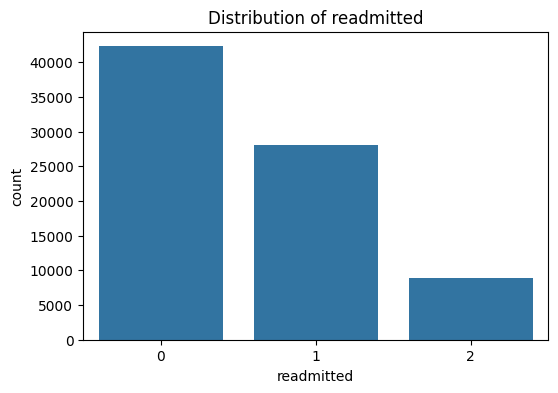

admission_type           8195
admission_source         5535
discharge_disposition    3731
race                     1790
dtype: int64


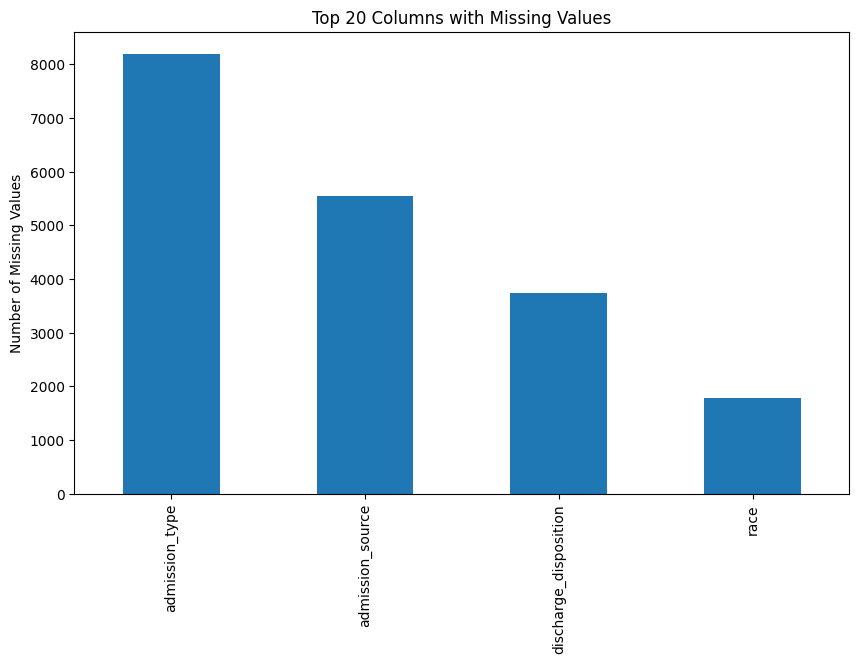

- race (5 unique): [ 1.  2. nan  3.  4.]...
- gender (2 unique): [1 0]...
- age (10 unique): [1 5 7 8 6]...
- admission_type (5 unique): [nan  1.  3.  2.  5.]...
- discharge_disposition (21 unique): [nan  2.  5.  0.  6.]...
- admission_source (14 unique): [ 1.  2.  3. nan  4.]...

Encounters per patient statistics:
count    55992.000000
mean         1.414184
std          1.081716
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         40.000000
Name: encounter_id, dtype: float64


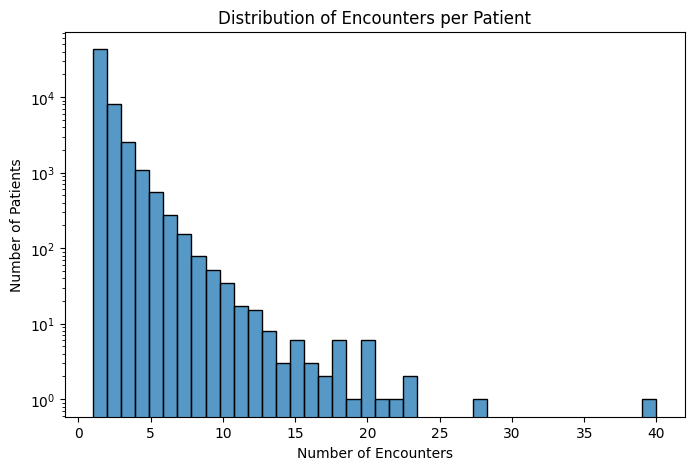

In [ ]:
# @title 05: Brief Exploratory Data Analysis (EDA)

# Target Variable Distribution
if TARGET_COLUMN in df.columns:
    print("Target variable distribution:")
    print(df[TARGET_COLUMN].value_counts(normalize=True) * 100)
    plt.figure(figsize=(6, 4))
    sns.countplot(x=TARGET_COLUMN, data=df, order=df[TARGET_COLUMN].value_counts().index)
    plt.title(f'Distribution of {TARGET_COLUMN}')
    plt.savefig('plots/target_distribution.png', dpi=PLOT_DPI)
    plt.show()
else:
    print("Target column not found for EDA.")

# Missing Values
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary.head(10))
if not missing_summary.empty:
    plt.figure(figsize=(10, 6))
    missing_summary.head(20).plot(kind='bar')
    plt.title('Top 20 Columns with Missing Values')
    plt.ylabel('Number of Missing Values')
    plt.savefig('plots/missing_values.png', dpi=PLOT_DPI)
    plt.show()
else:
    print("No missing values found in the dataset.")


# Unique values in key categorical features (examples)
sample_cat_cols_eda = ['race', 'gender', 'age', 'admission_type', 'discharge_disposition', 'admission_source']
for col in sample_cat_cols_eda:
    if col in df.columns:
        print(f"- {col} ({df[col].nunique()} unique): {df[col].unique()[:5]}...") # Show first 5
        # Check for '?' or other placeholders -> previously removed in other notebook, check if there are artifacts
        if '?' in df[col].unique():
            print(f"  Found '?' in column '{col}'")

# Number of encounters per patient
if 'patient_nbr' in df.columns:
    encounters_per_patient = df.groupby('patient_nbr')['encounter_id'].count()
    print("\nEncounters per patient statistics:")
    print(encounters_per_patient.describe())
    plt.figure(figsize=(8, 5))
    sns.histplot(encounters_per_patient, bins=min(50, encounters_per_patient.max()), kde=False)
    plt.title('Distribution of Encounters per Patient')
    plt.xlabel('Number of Encounters')
    plt.ylabel('Number of Patients')
    plt.yscale('log') # Often useful for skewed distributions
    plt.savefig('plots/encounters_per_patient.png', dpi=PLOT_DPI)
    plt.show()

In [ ]:
#@title 06: Categorical and numerical columns
df = df.sort_values(['patient_nbr', 'encounter_id']) # Ensure correct order
df['encounter_seq'] = df.groupby('patient_nbr').cumcount()

# Update Feature Column Lists
# These are the features that will go into the models
CONTINUOUS_COLS = CONTINUOUS_COLS_INIT + ['encounter_seq']
CATEGORICAL_COLS = CATEGORICAL_COLS_INIT
NUM_CLASSES = df[TARGET_COLUMN].nunique()

# Ensure columns are unique and exist in the dataframe
CONTINUOUS_COLS = sorted(list(set(col for col in CONTINUOUS_COLS if col in df.columns)))
CATEGORICAL_COLS = sorted(list(set(col for col in CATEGORICAL_COLS if col in df.columns)))

print(f"Continous cols: {CONTINUOUS_COLS}")
print(f"Categorical cols: {CATEGORICAL_COLS}")

# Columns to be used by the preprocessor (all features for modeling)
MODEL_FEATURES = CONTINUOUS_COLS + CATEGORICAL_COLS

Continous cols: ['encounter_seq', 'num_lab_procedures', 'num_medications', 'num_procedures', 'number_diagnoses', 'number_emergency', 'number_inpatient', 'number_outpatient', 'time_in_hospital']
Categorical cols: ['acarbose', 'admission_source', 'admission_type', 'age', 'change', 'chlorpropamide', 'diabetesMed', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'discharge_disposition', 'gender', 'glimepiride', 'glipizide', 'glyburide', 'glyburide-metformin', 'insulin', 'metformin', 'nateglinide', 'pioglitazone', 'race', 'repaglinide', 'rosiglitazone']


In [ ]:
# @title 07: Data Splitting
if 'patient_nbr' not in df.columns:
    raise ValueError("Patient identifier 'patient_nbr' column is missing for patient-level split.")

unique_patients = df['patient_nbr'].unique()
num_total_patients = len(unique_patients)
print(f"Total unique patients: {num_total_patients}")

# Shuffle patients to ensure random splits
np.random.shuffle(unique_patients)

# Calculate split points
train_end_idx = int(TRAIN_PATIENT_PROP * num_total_patients)
val_end_idx = train_end_idx + int(VAL_PATIENT_PROP * num_total_patients)
eval_end_idx = val_end_idx + int(EVAL_PATIENT_PROP * num_total_patients)

# Assign patients to sets
train_patients = unique_patients[:train_end_idx]
val_patients = unique_patients[train_end_idx:val_end_idx]
eval_patients = unique_patients[val_end_idx:eval_end_idx]
holdout_patients = unique_patients[eval_end_idx:]

df_train = df[df['patient_nbr'].isin(train_patients)].copy()
df_val = df[df['patient_nbr'].isin(val_patients)].copy()
df_eval = df[df['patient_nbr'].isin(eval_patients)].copy()
df_holdout = df[df['patient_nbr'].isin(holdout_patients)].copy()

print(f"Train set:      {df_train.shape[0]:>6} encounters from {len(train_patients):>5} patients (~{len(train_patients)/num_total_patients*100:.1f}%)")
print(f"Validation set: {df_val.shape[0]:>6} encounters from {len(val_patients):>5} patients (~{len(val_patients)/num_total_patients*100:.1f}%)")
print(f"Evaluation set: {df_eval.shape[0]:>6} encounters from {len(eval_patients):>5} patients (~{len(eval_patients)/num_total_patients*100:.1f}%)")
print(f"Holdout set:    {df_holdout.shape[0]:>6} encounters from {len(holdout_patients):>5} patients (~{len(holdout_patients)/num_total_patients*100:.1f}%)")

# Check for patient overlap between sets (should be none due to slicing unique shuffled array)
assert len(set(train_patients) & set(val_patients)) == 0, "Patient overlap between train and val!"
assert len(set(train_patients) & set(eval_patients)) == 0, "Patient overlap between train and eval!"
assert len(set(val_patients) & set(eval_patients)) == 0, "Patient overlap between val and eval!"
assert len(set(eval_patients) & set(holdout_patients)) == 0, "Patient overlap between eval and holdout!"
assert len(set(train_patients) & set(holdout_patients)) == 0, "Patient overlap between train and holdout!"
assert len(set(val_patients) & set(holdout_patients)) == 0, "Patient overlap between val and holdout!"

# Ensure MODEL_FEATURES and identifiers are present before selecting
required_cols_for_X_df = MODEL_FEATURES + ['patient_nbr', 'encounter_id']
for col in required_cols_for_X_df:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' required for X_df creation is missing from the main dataframe 'df'.")
if TARGET_COLUMN not in df.columns:
     raise KeyError(f"Target column '{TARGET_COLUMN}' is missing from the main dataframe 'df'.")


X_train_df = df_train[required_cols_for_X_df].copy()
y_train = df_train[TARGET_COLUMN].values
X_val_df = df_val[required_cols_for_X_df].copy()
y_val = df_val[TARGET_COLUMN].values
X_eval_df = df_eval[required_cols_for_X_df].copy()
y_eval = df_eval[TARGET_COLUMN].values
X_holdout_df = df_holdout[required_cols_for_X_df].copy()
y_holdout = df_holdout[TARGET_COLUMN].values

print(f"\nShapes: X_train_df: {X_train_df.shape}, y_train: {y_train.shape}")
print(f"Num unique patients in train_patients list: {len(np.unique(train_patients))}")
print(f"Num unique patients in val_patients list:   {len(np.unique(val_patients))}")
print(f"Num unique patients in eval_patients list:  {len(np.unique(eval_patients))}")
print(f"Num unique patients in holdout_patients list: {len(np.unique(holdout_patients))}")

Total unique patients: 55992
Train set:       47586 encounters from 33595 patients (~60.0%)
Validation set:   7932 encounters from  5599 patients (~10.0%)
Evaluation set:  11846 encounters from  8398 patients (~15.0%)
Holdout set:     11819 encounters from  8400 patients (~15.0%)

Shapes: X_train_df: (47586, 34), y_train: (47586,)
Num unique patients in train_patients list: 33595
Num unique patients in val_patients list:   5599
Num unique patients in eval_patients list:  8398
Num unique patients in holdout_patients list: 8400


In [ ]:
# @title 08: Preprocessing Pipeline

# Identify columns for KNN imputation based on missing percentage in training data
missing_pct_train = X_train_df[MODEL_FEATURES].isnull().mean()

knn_impute_cols = [
    col for col in CONTINUOUS_COLS
    if col in X_train_df.columns and missing_pct_train.get(col, 0) >= MISSING_THRESHOLD_FOR_KNN
]
simple_impute_cols = [
    col for col in CONTINUOUS_COLS
    if col in X_train_df.columns and col not in knn_impute_cols
]
# Ensure categorical columns for OHE are valid
valid_cat_cols_preprocess = [col for col in CATEGORICAL_COLS if col in X_train_df.columns]

# Define preprocessing steps
transformers_list = []

if simple_impute_cols:
    numerical_simple_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    transformers_list.append(('num_simple', numerical_simple_transformer, simple_impute_cols))

if knn_impute_cols:
    numerical_knn_transformer = Pipeline([
        ('imputer', KNNImputer(n_neighbors=KNN_NEIGHBORS)),
        ('scaler', StandardScaler())
    ])
    transformers_list.append(('num_knn', numerical_knn_transformer, knn_impute_cols))

if valid_cat_cols_preprocess:
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # Handles NaN (incl. replaced '?')
        ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
    ])
    transformers_list.append(('cat', categorical_transformer, valid_cat_cols_preprocess))

if not transformers_list:
    raise ValueError("No transformers were added to the preprocessor. Check column definitions and data.")

preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='drop',
    n_jobs=-1
)

# Fit preprocessor on training data features (X_train_df contains only MODEL_FEATURES for fitting)
preprocessor.fit(X_train_df[MODEL_FEATURES])

# Transform all data splits
X_train_final = preprocessor.transform(X_train_df[MODEL_FEATURES])
X_val_final = preprocessor.transform(X_val_df[MODEL_FEATURES])
X_eval_final = preprocessor.transform(X_eval_df[MODEL_FEATURES])
X_holdout_final = preprocessor.transform(X_holdout_df[MODEL_FEATURES])

print(f"\nShape of X_train_final: {X_train_final.shape}")
print(f"Shape of X_val_final: {X_val_final.shape}")
print(f"Shape of X_eval_final: {X_eval_final.shape}")
print(f"Shape of X_holdout_final: {X_holdout_final.shape}")

# Save the preprocessor
preprocessor_filename = 'models/preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_filename)

# Display feature names if possible
try:
    feature_names_out = preprocessor.get_feature_names_out()
    print(f"Number of features after preprocessing: {len(feature_names_out)}")
    if len(feature_names_out) < 20 : print(f"Feature names: {feature_names_out}")
    else: print(f"First 10 feature names: {feature_names_out[:10]}")
except:
    print("error")
    NUM_PROC_FEATURES = X_train_final.shape[1]
else:
    NUM_PROC_FEATURES = len(feature_names_out)


Shape of X_train_final: (47586, 149)
Shape of X_val_final: (7932, 149)
Shape of X_eval_final: (11846, 149)
Shape of X_holdout_final: (11819, 149)
Number of features after preprocessing: 149
First 10 feature names: ['num_simple__encounter_seq' 'num_simple__num_lab_procedures'
 'num_simple__num_medications' 'num_simple__num_procedures'
 'num_simple__number_diagnoses' 'num_simple__number_emergency'
 'num_simple__number_inpatient' 'num_simple__number_outpatient'
 'num_simple__time_in_hospital' 'cat__acarbose_0.0']


In [ ]:
# @title 09: Class weights calculation
# Ensure y_train is 1D array of integers
if y_train.ndim > 1: y_train = y_train.ravel()

unique_classes_train = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes_train}")
print(f"Class distribution in y_train: {np.bincount(y_train[y_train >= 0])}") # Ensure no negative indices if any errors

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes_train,
    y=y_train
)

CLASS_WEIGHTS_TENSOR = torch.FloatTensor(class_weights_array).to(DEVICE)

print(f"Computed class weights (for labels {unique_classes_train}): {class_weights_array}")
print(f"Class weights tensor for PyTorch (on {DEVICE}): {CLASS_WEIGHTS_TENSOR}")

Unique classes in y_train: [0 1 2]
Class distribution in y_train: [25348 16898  5340]
Computed class weights (for labels [0 1 2]): [0.62576929 0.93869097 2.97041199]
Class weights tensor for PyTorch (on cuda): tensor([0.6258, 0.9387, 2.9704], device='cuda:0')


In [ ]:
# @title 10: Baseline Models
# Logistic Regression
lr_model = LogisticRegression(
    class_weight='balanced', #due to imbalance in target value
    max_iter=LR_MAX_ITER,
    random_state=SEED,
    multi_class='multinomial',
    solver='lbfgs',
    n_jobs=-1
)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1,
    max_depth=RF_MAX_DEPTH,
    min_samples_split=RF_MIN_SAMPLES_SPLIT
)
rf_model.fit(X_train_final, y_train)

# Quick check on validation set (full evaluation later on evaluation_set)
lr_val_preds = lr_model.predict(X_val_final)
rf_val_preds = rf_model.predict(X_val_final)

print("Model perfomance on validation set:")
print(f"Logistic Regression Val F1: {f1_score(y_val, lr_val_preds, average='macro'):.4f}")
print(f"Random Forest Val F1: {f1_score(y_val, rf_val_preds, average='macro'):.4f}")

# Save baseline models
joblib.dump(lr_model, 'models/lr_model.pkl')
joblib.dump(rf_model, 'models/rf_model.pkl')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model perfomance on validation set:
Logistic Regression Val F1: 0.4389
Random Forest Val F1: 0.4366


['models/rf_model.pkl']

In [ ]:
# @title 11: Graphs
def create_graph_data_pyg(df_split_meta, X_features_split, y_labels_split, patient_col='patient_nbr', encounter_seq_col='encounter_seq'):
    """
    Creates pytorch geometric data object
    """
    x = torch.FloatTensor(X_features_split)
    y = torch.LongTensor(y_labels_split)
    edge_list = []

    original_to_node_idx = {original_idx: i for i, original_idx in enumerate(df_split_meta.index)}

    for _, patient_df in tqdm(df_split_meta.groupby(patient_col), desc="Building Edges for Split"):
        # Sort encounters for this patient by sequence number
        patient_encounters_sorted = patient_df.sort_values(encounter_seq_col)
        original_indices = patient_encounters_sorted.index.tolist()
        node_indices = [original_to_node_idx[orig_idx] for orig_idx in original_indices]

        # Create temporal edges (encounter_i -> encounter_i+1) and reverse for bidirectionality
        for i in range(len(node_indices) - 1):
            idx_curr = node_indices[i]
            idx_next = node_indices[i+1]
            edge_list.append([idx_curr, idx_next])
            edge_list.append([idx_next, idx_curr]) # Bidirectional

    # Add self-loops for all nodes
    num_nodes = X_features_split.shape[0]
    self_loops = [[i, i] for i in range(num_nodes)]
    edge_list.extend(self_loops)

    if edge_list:
        edge_index = torch.LongTensor(edge_list).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, y=y)
    data.num_nodes = num_nodes
    return data

train_data = create_graph_data_pyg(X_train_df, X_train_final, y_train)
print(f"Train_data: {train_data}, Nodes: {train_data.num_nodes}, Edges: {train_data.num_edges}")

val_data = create_graph_data_pyg(X_val_df, X_val_final, y_val)
print(f"Val_data: {val_data}, Nodes: {val_data.num_nodes}, Edges: {val_data.num_edges}")

eval_data = create_graph_data_pyg(X_eval_df, X_eval_final, y_eval)
print(f"Eval_data: {eval_data}, Nodes: {eval_data.num_nodes}, Edges: {eval_data.num_edges}")

holdout_data = create_graph_data_pyg(X_holdout_df, X_holdout_final, y_holdout)
print(f"Holdout_data: {holdout_data}, Nodes: {holdout_data.num_nodes}, Edges: {holdout_data.num_edges}")

# Sanity checks
print(f"\nTrain_data isolated nodes: {train_data.has_isolated_nodes()}, self_loops: {train_data.has_self_loops()}")

Building Edges for Split:   0%|          | 0/33595 [00:00<?, ?it/s]

Train_data: Data(x=[47586, 149], edge_index=[2, 75568], y=[47586], num_nodes=47586), Nodes: 47586, Edges: 75568


Building Edges for Split:   0%|          | 0/5599 [00:00<?, ?it/s]

Val_data: Data(x=[7932, 149], edge_index=[2, 12598], y=[7932], num_nodes=7932), Nodes: 7932, Edges: 12598


Building Edges for Split:   0%|          | 0/8398 [00:00<?, ?it/s]

Eval_data: Data(x=[11846, 149], edge_index=[2, 18742], y=[11846], num_nodes=11846), Nodes: 11846, Edges: 18742


Building Edges for Split:   0%|          | 0/8400 [00:00<?, ?it/s]

Holdout_data: Data(x=[11819, 149], edge_index=[2, 18657], y=[11819], num_nodes=11819), Nodes: 11819, Edges: 18657

Train_data isolated nodes: True, self_loops: True


<ipython-input-37-79383184ab2d>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


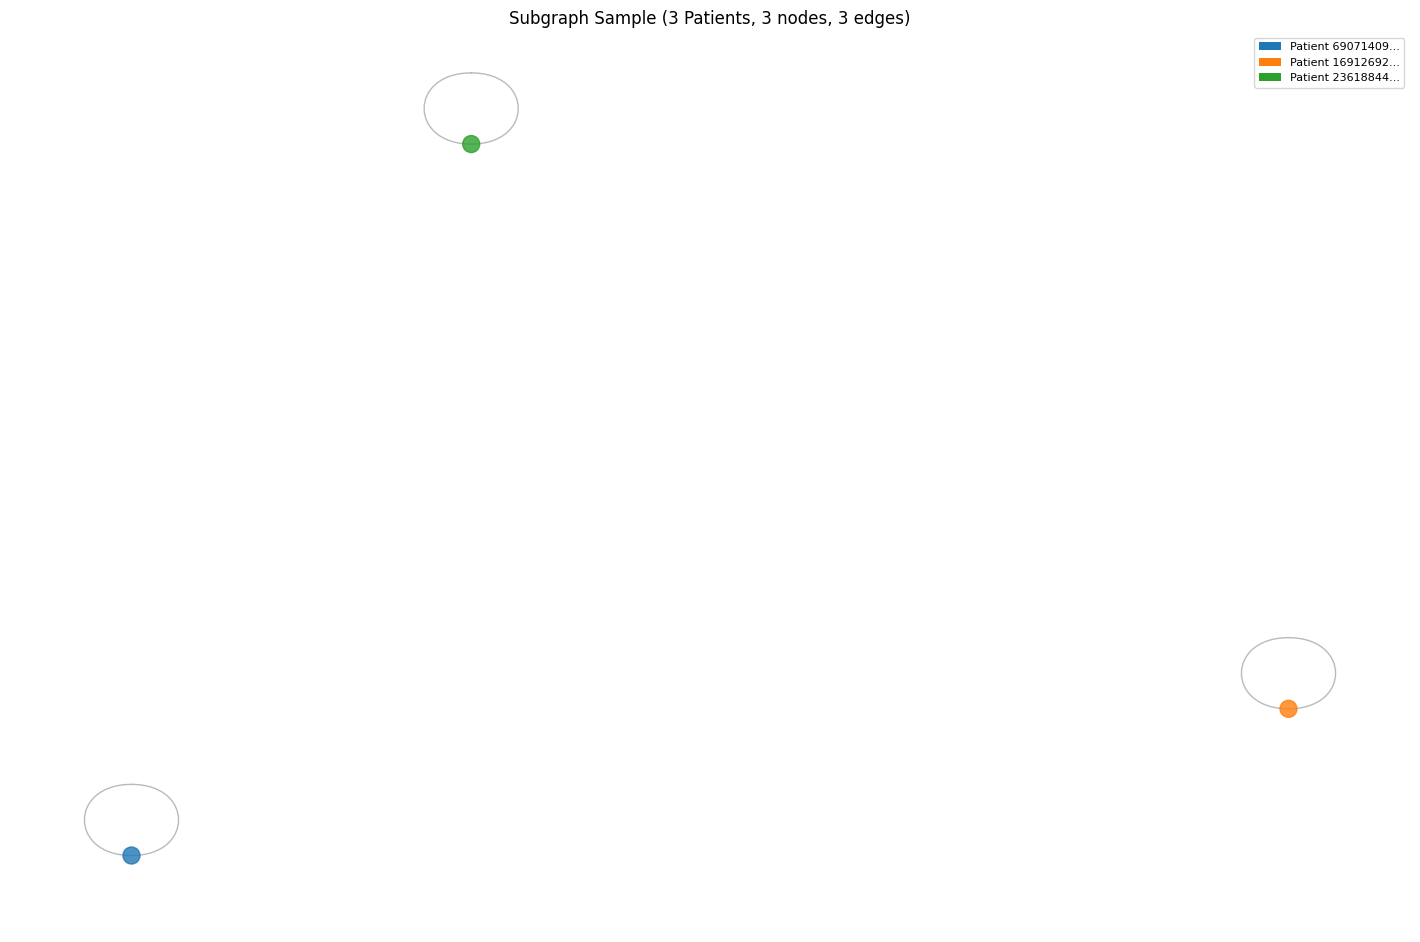

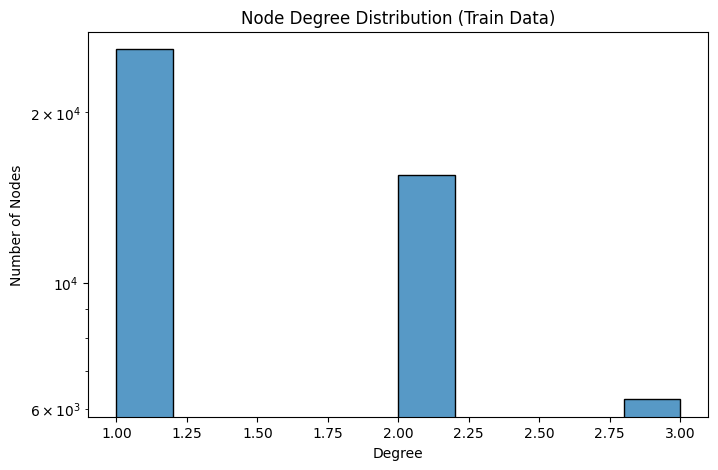

Average node degree: 1.59
Could not do conversion, skipping this part

Average encounters per patient in train set: 1.42


In [ ]:
# @title 12: Graph structure analysis and visualization
# Visualize a Sample Subgraph (using function from original script, slightly adapted)
def visualize_pyg_graph_sample(pyg_data, df_ref_meta, num_patients_to_show=5, save_path='plots/graph_structure_sample.png'):
    plt.figure(figsize=(14, 9))
    all_patient_ids = df_ref_meta['patient_nbr'].unique()
    if len(all_patient_ids) == 0: print("No patients in df_ref_meta."); return
    sample_patient_ids = np.random.choice(all_patient_ids, size=min(num_patients_to_show, len(all_patient_ids)), replace=False)

    sample_df_indices = df_ref_meta[df_ref_meta['patient_nbr'].isin(sample_patient_ids)].index
    original_to_node_idx_map = {original_idx: i for i, original_idx in enumerate(df_ref_meta.index)}
    sample_node_indices_set = {original_to_node_idx_map[df_idx] for df_idx in sample_df_indices if df_idx in original_to_node_idx_map}

    if not sample_node_indices_set: print("No nodes for sample patients."); return

    G_nx = nx.Graph() # Use Graph for undirected visualization
    edge_index_np = pyg_data.edge_index.cpu().numpy()

    nodes_to_add_to_nx = set()
    for i in range(edge_index_np.shape[1]):
        src, dst = edge_index_np[0, i], edge_index_np[1, i]
        if src in sample_node_indices_set and dst in sample_node_indices_set:
            G_nx.add_edge(src, dst)
            nodes_to_add_to_nx.add(src)
            nodes_to_add_to_nx.add(dst)
    # Add isolated sample nodes too
    for node_idx in sample_node_indices_set:
        if node_idx not in nodes_to_add_to_nx : G_nx.add_node(node_idx)


    if G_nx.number_of_nodes() == 0: print("Sample graph is empty."); return

    patient_color_map = {pid: plt.cm.tab10(i % 10) for i, pid in enumerate(sample_patient_ids)}
    node_colors = []
    node_to_original_idx_map = {v: k for k, v in original_to_node_idx_map.items()}
    for node in G_nx.nodes():
        original_df_idx = node_to_original_idx_map.get(node)
        patient_nbr = df_ref_meta.loc[original_df_idx, 'patient_nbr'] if original_df_idx is not None else None
        node_colors.append(patient_color_map.get(patient_nbr, 'grey'))

    pos = nx.spring_layout(G_nx, k=0.9, iterations=40, seed=SEED)
    nx.draw(G_nx, pos, node_color=node_colors, node_size=150, with_labels=False, edge_color='darkgrey', alpha=0.8, width=1.0)

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=patient_color_map[pid], label=f'Patient {str(pid)[:10]}...') for pid in sample_patient_ids]
    plt.legend(handles=legend_elements, loc='best', fontsize=8)
    plt.title(f'Subgraph Sample ({len(sample_patient_ids)} Patients, {G_nx.number_of_nodes()} nodes, {G_nx.number_of_edges()} edges)', fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=PLOT_DPI)
    plt.show()

visualize_pyg_graph_sample(train_data, X_train_df, num_patients_to_show=3) # X_train_df has patient_nbr

# Degree Distribution
degrees_tensor = degree(train_data.edge_index[0], num_nodes=train_data.num_nodes)
degrees = degrees_tensor.cpu().numpy()

plt.figure(figsize=(8, 5))
sns.histplot(degrees, bins=max(10, min(50, int(np.max(degrees))+1 if len(degrees)>0 else 1)), kde=False)
plt.title('Node Degree Distribution (Train Data)')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.yscale('log')
plt.savefig('plots/degree_distribution.png', dpi=PLOT_DPI)
plt.show()
print(f"Average node degree: {np.mean(degrees):.2f}" if len(degrees)>0 else "Average node degree: N/A")

# Connected Components (for the entire training graph)
try:
    G_train_nx_full = to_networkx(train_data, to_undirected=True, remove_self_loops=True)
    num_connected_components = nx.number_connected_components(G_train_nx_full)
    print(f"\nNumber of connected components in the full training graph: {num_connected_components}")
    if num_connected_components > train_data.num_nodes * 0.5 : # Heuristic
        print("Warning: Graph is highly fragmented. Each patient's encounter sequence is a component due to construction.")
    largest_cc = max(nx.connected_components(G_train_nx_full), key=len)
    print(f"Size of the largest connected component: {len(largest_cc)} nodes")
except:
    print("Could not do conversion, skipping this part")



# Average number of encounters per patient (already in EDA, but relevant to graph)
if 'patient_nbr' in X_train_df.columns:
    avg_enc_train = X_train_df.groupby('patient_nbr')['encounter_id'].count().mean()
    print(f"\nAverage encounters per patient in train set: {avg_enc_train:.2f}")

In [ ]:
# @title 13: GNN Model Definition
# (Using the same AdvancedGNN definition as provided in the original script)
class AdvancedGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout,
                 num_layers, gnn_type='SAGE'):
        super(AdvancedGNN, self).__init__()
        self.num_layers = num_layers
        self.gnn_type = gnn_type.upper()
        self.dropout_rate = dropout

        self.input_proj = torch.nn.Sequential(
            torch.nn.Linear(num_features, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.dropout_rate)
        )

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        current_dim = hidden_dim

        for i in range(num_layers):
            if self.gnn_type == 'SAGE':
                self.convs.append(SAGEConv(current_dim, hidden_dim))
            elif self.gnn_type == 'GAT':
                gat_heads = 1 # Or 2, then output_dim = hidden_dim // heads if concat else hidden_dim
                self.convs.append(GATConv(current_dim, hidden_dim // gat_heads if gat_heads > 1 else hidden_dim,
                                          heads=gat_heads, concat=gat_heads > 1, dropout=self.dropout_rate))
                if gat_heads > 1 and True:
                     current_dim = hidden_dim # Stays hidden_dim because output is hidden_dim (hidden_dim//gat_heads * gat_heads)
            elif self.gnn_type == 'GIN':
                mlp = torch.nn.Sequential(
                    torch.nn.Linear(current_dim, hidden_dim * 2), # GIN often uses 2x dim internally
                    torch.nn.BatchNorm1d(hidden_dim * 2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim * 2, hidden_dim),
                    torch.nn.Dropout(self.dropout_rate)
                )
                self.convs.append(GINConv(mlp, train_eps=True)) # train_eps is GIN specific
            else:
                raise ValueError(f"Unsupported GNN type: {self.gnn_type}")
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))
            current_dim = hidden_dim # For next layer input if GAT was adjusted

        # Attention mechanism for node importance (applied to final GNN embeddings)
        self.attention_layer = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        )

        # Classifier head (as per original script)
        classifier_input_dim = hidden_dim * 3
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(classifier_input_dim, hidden_dim * 2), # Matched to 3*hidden_dim
            torch.nn.BatchNorm1d(hidden_dim * 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.dropout_rate),
            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.dropout_rate),
            torch.nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_index, batch=None): # batch is for PyG batching, not used here for full graph
        x = self.input_proj(x)
        for i in range(self.num_layers):
            x_residual = x
            if self.gnn_type == 'GIN':
                x = self.convs[i](x, edge_index)
            else: # SAGE, GAT
                x = self.convs[i](x, edge_index)

            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
            if x.shape == x_residual.shape: # Ensure shapes match for residual (esp. if GAT changes dim)
                x = x + x_residual
            else: # If GAT changed dim and wasn't projected back
                print("Residual connection skip due to shape mismatch")


        attention_weights = self.attention_layer(x)
        x_attended = x * attention_weights

        x_combined = torch.cat([x, x, x_attended], dim=1)
        out = self.classifier(x_combined)
        return F.log_softmax(out, dim=1), attention_weights # Return attention weights for explainability


In [ ]:
# @title 14: GNN Training Setup
gnn_model = AdvancedGNN(
    num_features=NUM_PROC_FEATURES, # From preprocessor
    hidden_dim=GNN_HIDDEN_DIM,
    num_classes=NUM_CLASSES, # From target processing
    dropout=GNN_DROPOUT,
    num_layers=GNN_NUM_LAYERS,
    gnn_type=GNN_TYPE
).to(DEVICE)

print("Initialized GNN model: ")
print(gnn_model)
total_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

# Data to device
train_data = train_data.to(DEVICE)
val_data = val_data.to(DEVICE)
# eval_data and holdout_data will be moved to device during evaluation

# Optimizer, Scheduler, Criterion
optimizer = torch.optim.AdamW(gnn_model.parameters(), lr=GNN_LEARNING_RATE, weight_decay=GNN_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=GNN_PATIENCE // 2, verbose=True) # Adjust patience
criterion = torch.nn.CrossEntropyLoss(weight=CLASS_WEIGHTS_TENSOR)


Initialized GNN model: 
AdvancedGNN(
  (input_proj): Sequential(
    (0): Linear(in_features=149, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (convs): ModuleList(
    (0-2): 3 x SAGEConv(128, 128, aggr=mean)
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (attention_layer): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# @title 15: GNN Training Loop
best_val_metric = 0.0 # Using F1-macro on validation set
patience_counter = 0
best_model_epoch = -1
best_gnn_model_state_dict = None

train_epoch_losses = []
val_epoch_losses = []
val_epoch_f1s = []
learning_rates = []

for epoch in range(GNN_EPOCHS):
    gnn_model.train()
    optimizer.zero_grad()

    out, _ = gnn_model(train_data.x, train_data.edge_index) # Ignore attention weights during training loss calc
    loss = criterion(out, train_data.y)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.0) # Gradient clipping
    optimizer.step()
    train_epoch_losses.append(loss.item())

    # Validation
    gnn_model.eval()
    with torch.no_grad():
        val_out, _ = gnn_model(val_data.x, val_data.edge_index)
        val_loss = criterion(val_out, val_data.y)
        val_epoch_losses.append(val_loss.item())

        val_pred_labels = val_out.argmax(dim=1).cpu().numpy()
        y_val_np = val_data.y.cpu().numpy()
        val_f1 = f1_score(y_val_np, val_pred_labels, average='macro', zero_division=0)
        val_epoch_f1s.append(val_f1)

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    scheduler.step(val_f1) # ReduceLROnPlateau based on validation F1

    print_msg = (f"Epoch {epoch+1}/{GNN_EPOCHS} - Train Loss: {loss.item():.4f}, "
                 f"Val Loss: {val_loss.item():.4f}, Val F1: {val_f1:.4f}, LR: {current_lr:.1e}")

    if val_f1 > best_val_metric:
        best_val_metric = val_f1
        best_model_epoch = epoch
        # Save the model state dict, not the whole model for flexibility
        best_gnn_model_state_dict = gnn_model.state_dict()
        patience_counter = 0
        print(print_msg + " (New Best!)")
    else:
        patience_counter += 1
        if (epoch + 1) % 10 == 0 or patience_counter == GNN_PATIENCE : # Print periodically
             print(print_msg)

    if patience_counter >= GNN_PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1} (Patience: {GNN_PATIENCE}).")
        print(f"Best Validation F1: {best_val_metric:.4f} at epoch {best_model_epoch+1}.")
        break

if epoch == GNN_EPOCHS -1 and best_gnn_model_state_dict is not None: # Check if loop completed all epochs
    print(f"\nFinished training for {GNN_EPOCHS} epochs.")
    print(f"Best Validation F1: {best_val_metric:.4f} at epoch {best_model_epoch+1}.")

# Load the best model state if found
if best_gnn_model_state_dict:
    gnn_model.load_state_dict(best_gnn_model_state_dict)


Epoch 1/400 - Train Loss: 1.1843, Val Loss: 1.0938, Val F1: 0.2273, LR: 1.0e-03 (New Best!)
Epoch 2/400 - Train Loss: 1.1310, Val Loss: 1.0910, Val F1: 0.3927, LR: 1.0e-03 (New Best!)
Epoch 5/400 - Train Loss: 1.0704, Val Loss: 1.0820, Val F1: 0.4129, LR: 1.0e-03 (New Best!)
Epoch 10/400 - Train Loss: 1.0250, Val Loss: 1.0578, Val F1: 0.3619, LR: 1.0e-03
Epoch 13/400 - Train Loss: 0.9956, Val Loss: 1.0339, Val F1: 0.4176, LR: 1.0e-03 (New Best!)
Epoch 14/400 - Train Loss: 0.9898, Val Loss: 1.0253, Val F1: 0.4324, LR: 1.0e-03 (New Best!)
Epoch 15/400 - Train Loss: 0.9798, Val Loss: 1.0173, Val F1: 0.4402, LR: 1.0e-03 (New Best!)
Epoch 16/400 - Train Loss: 0.9730, Val Loss: 1.0106, Val F1: 0.4429, LR: 1.0e-03 (New Best!)
Epoch 20/400 - Train Loss: 0.9382, Val Loss: 1.0010, Val F1: 0.3959, LR: 1.0e-03
Epoch 28/400 - Train Loss: 0.8784, Val Loss: 0.9349, Val F1: 0.4493, LR: 1.0e-03 (New Best!)
Epoch 29/400 - Train Loss: 0.8726, Val Loss: 0.9143, Val F1: 0.4706, LR: 1.0e-03 (New Best!)
Epoc

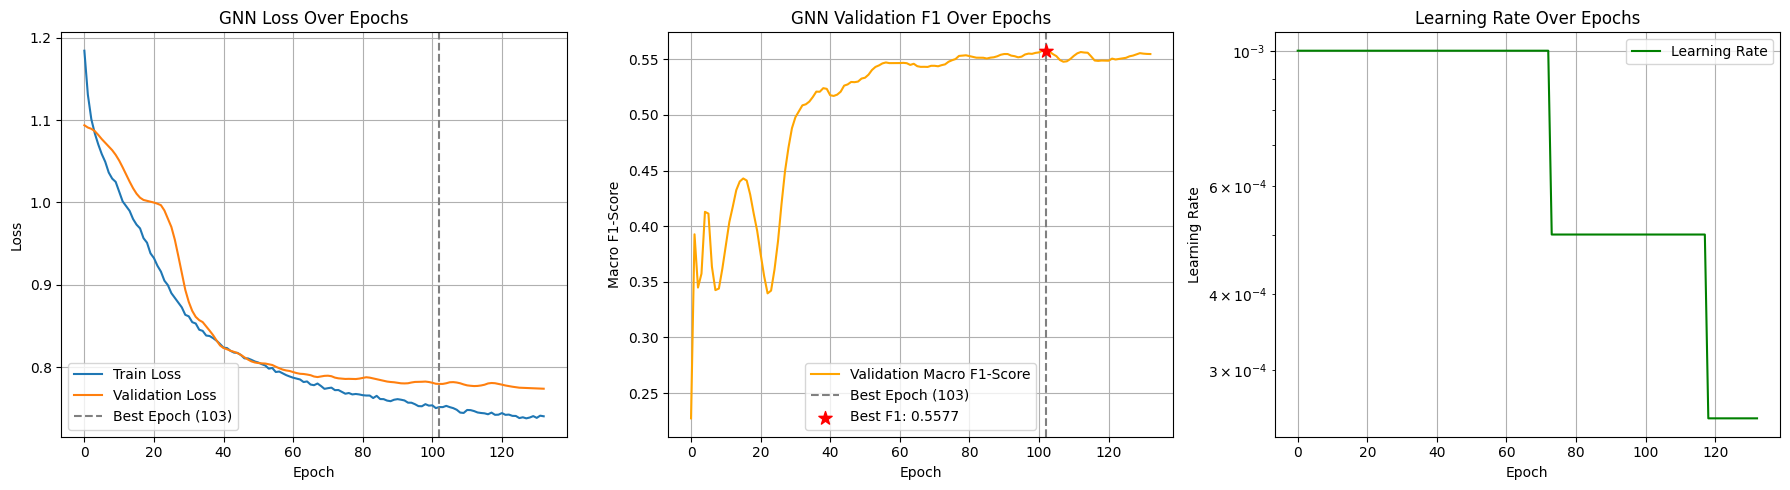

In [ ]:
# @title 16: Plot GNN Training History
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(train_epoch_losses, label='Train Loss')
plt.plot(val_epoch_losses, label='Validation Loss')
if best_model_epoch != -1:
    plt.axvline(x=best_model_epoch, color='grey', linestyle='--', label=f'Best Epoch ({best_model_epoch+1})')
plt.title('GNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_epoch_f1s, label='Validation Macro F1-Score', color='orange')
if best_model_epoch != -1:
    plt.axvline(x=best_model_epoch, color='grey', linestyle='--', label=f'Best Epoch ({best_model_epoch+1})')
    plt.scatter(best_model_epoch, best_val_metric, marker='*', s=100, color='red', zorder=5, label=f'Best F1: {best_val_metric:.4f}')
plt.title('GNN Validation F1 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Macro F1-Score')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(learning_rates, label='Learning Rate', color='green')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log') # LR often changes by factors
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('plots/gnn_training_history.png', dpi=PLOT_DPI)
plt.show()

In [ ]:
# @title 17: Save Best GNN Model
if best_gnn_model_state_dict:
    best_gnn_model_filename = f'models/best_gnn_model_{GNN_TYPE}.pt'
    torch.save(best_gnn_model_state_dict, best_gnn_model_filename)
else:
    print("No 'best_gnn_model_state_dict' was captured. Saving current GNN model state instead.")
    current_gnn_model_filename = f'models/current_gnn_model_{GNN_TYPE}.pt'
    torch.save(gnn_model.state_dict(), current_gnn_model_filename)

  Logistic Regression            Acc=0.5015, F1_macro=0.4365, MCC=0.1832, AUC=0.6550
  Random Forest                  Acc=0.5064, F1_macro=0.4317, MCC=0.1850, AUC=0.6622
  GNN (SAGE - Full)              Acc=0.6504, F1_macro=0.5584, MCC=0.4431, AUC=0.8244
  GNN (SAGE - Self-Loops)        Acc=0.5046, F1_macro=0.4158, MCC=0.1721, AUC=0.6474
  Ensemble (LR+GNN)              Acc=0.6383, F1_macro=0.5563, MCC=0.4235, AUC=0.8153


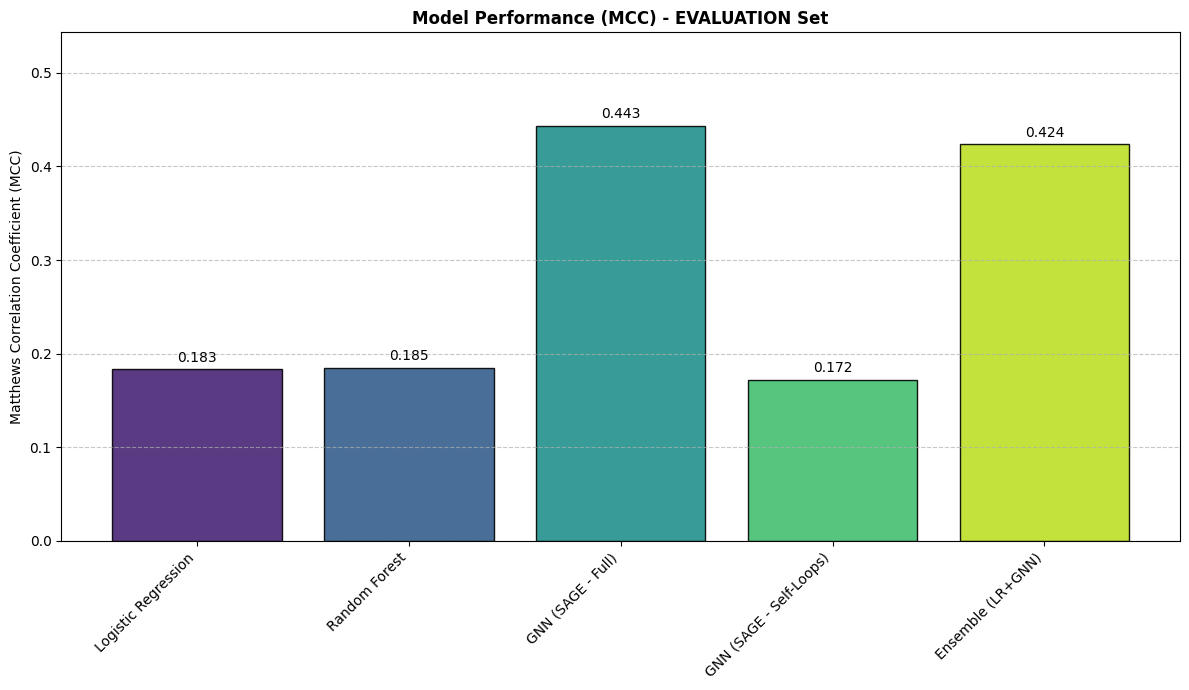

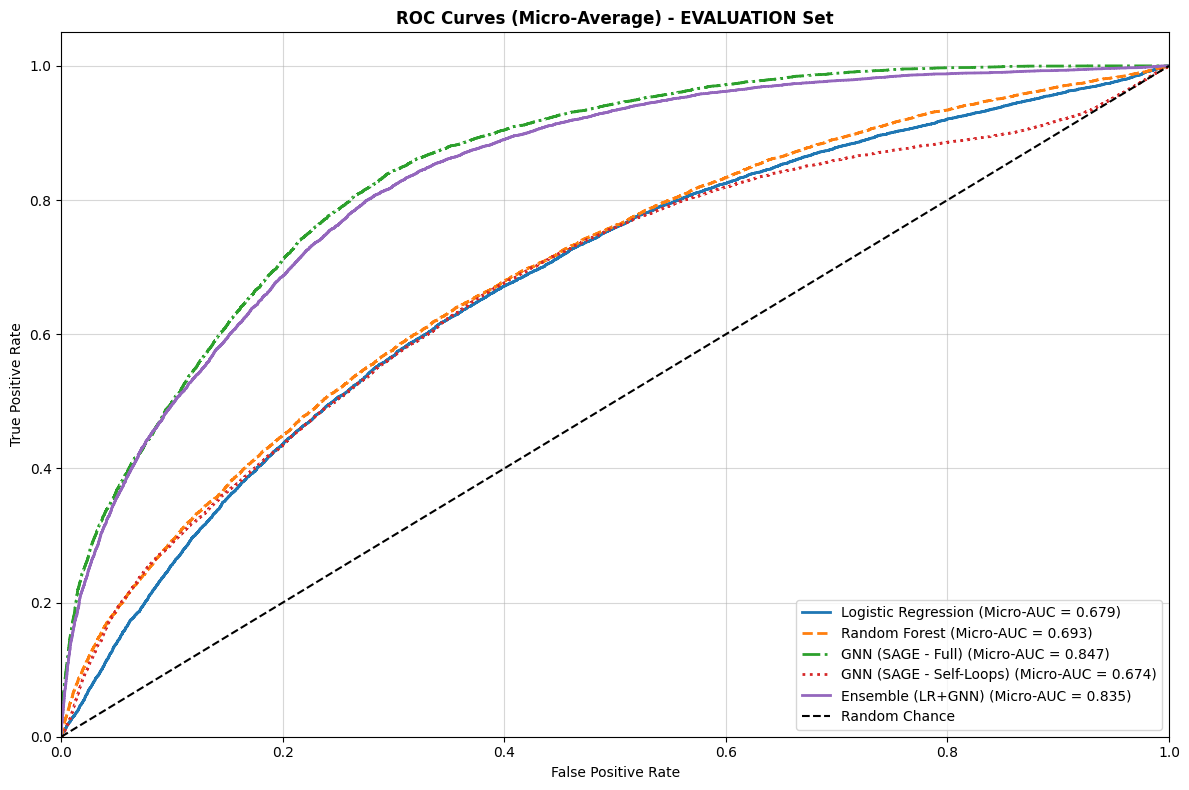

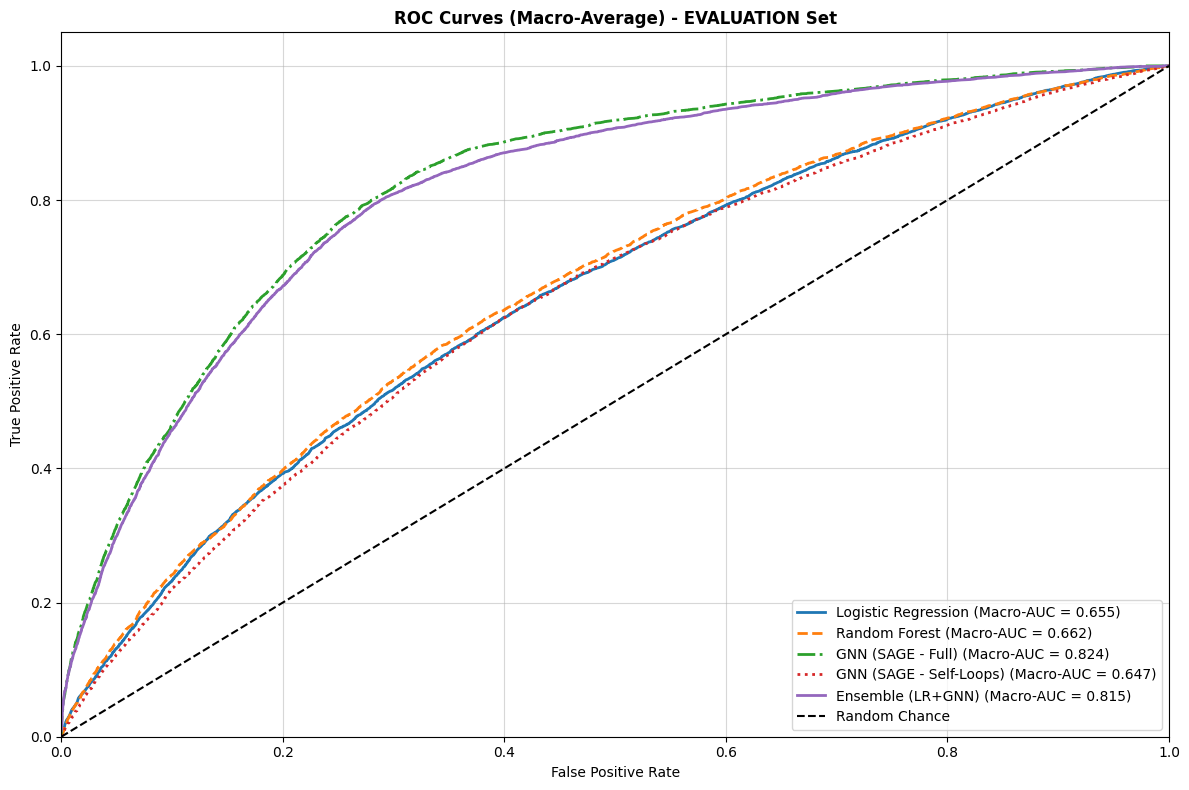

In [ ]:
# @title 18: Model Evaluation
# Load best GNN model if not already loaded
if best_gnn_model_state_dict:
    gnn_model.load_state_dict(best_gnn_model_state_dict)
gnn_model.eval()  # Ensure it's in eval mode

# Function to get predictions and probabilities
def get_all_preds_probs(model_obj, data_input_X, data_input_pyg=None, is_gnn=True, gnn_device=DEVICE):
    if is_gnn:
        model_obj.to(gnn_device)
        data_pyg_on_device = data_input_pyg.to(gnn_device)
        with torch.no_grad():
            out, _ = model_obj(data_pyg_on_device.x, data_pyg_on_device.edge_index)
            probs = F.softmax(out, dim=1).cpu().numpy()
            preds = out.argmax(dim=1).cpu().numpy()
        return preds, probs
    else:  # Scikit-learn model
        return model_obj.predict(data_input_X), model_obj.predict_proba(data_input_X)

# Get predictions for all models on the EVALUATION set
eval_predictions_results = {}
y_eval_np = y_eval.ravel()  # Ensure 1D

lr_eval_preds, lr_eval_probs = get_all_preds_probs(lr_model, X_eval_final, is_gnn=False)
eval_predictions_results['Logistic Regression'] = (lr_eval_preds, lr_eval_probs)

rf_eval_preds, rf_eval_probs = get_all_preds_probs(rf_model, X_eval_final, is_gnn=False)
eval_predictions_results['Random Forest'] = (rf_eval_preds, rf_eval_probs)

gnn_full_eval_preds, gnn_full_eval_probs = get_all_preds_probs(gnn_model, None, eval_data, is_gnn=True)
eval_predictions_results[f'GNN ({GNN_TYPE} - Full)'] = (gnn_full_eval_preds, gnn_full_eval_probs)

eval_data_sl = eval_data.clone()
num_eval_nodes = eval_data_sl.num_nodes
self_loop_edges_eval = torch.arange(0, num_eval_nodes, dtype=torch.long)
eval_data_sl.edge_index = torch.stack([self_loop_edges_eval, self_loop_edges_eval], dim=0)
gnn_sl_eval_preds, gnn_sl_eval_probs = get_all_preds_probs(gnn_model, None, eval_data_sl, is_gnn=True)
eval_predictions_results[f'GNN ({GNN_TYPE} - Self-Loops)'] = (gnn_sl_eval_preds, gnn_sl_eval_probs)

ensemble_eval_probs = (ENSEMBLE_WEIGHT_LR * lr_eval_probs) + (ENSEMBLE_WEIGHT_GNN * gnn_full_eval_probs)
ensemble_eval_preds = ensemble_eval_probs.argmax(axis=1)
eval_predictions_results['Ensemble (LR+GNN)'] = (ensemble_eval_preds, ensemble_eval_probs)

# Calculate and store metrics for the EVALUATION set
evaluation_set_metrics = {}
for name, (preds, probs) in eval_predictions_results.items():
    accuracy = accuracy_score(y_eval_np, preds)
    f1_macro = f1_score(y_eval_np, preds, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_eval_np, preds)
    try:
        roc_auc_val = roc_auc_score(y_eval_np, probs, multi_class='ovr', average='macro')
    except ValueError as e:
        print(f"Warning: ROC AUC for {name} failed: {e}. Setting to NaN.")
        roc_auc_val = np.nan

    evaluation_set_metrics[name] = {
        'accuracy': accuracy, 'f1_macro': f1_macro, 'mcc': mcc, 'roc_auc': roc_auc_val
    }
    print(f"  {name:<30} Acc={accuracy:.4f}, F1_macro={f1_macro:.4f}, MCC={mcc:.4f}, AUC={roc_auc_val:.4f}")

# Visualizations for evaluation set performance
# MCC Comparison Histogram
plt.figure(figsize=(12, 7))
model_names_eval = list(evaluation_set_metrics.keys())
mcc_scores_eval = [evaluation_set_metrics[name]['mcc'] for name in model_names_eval]
colors_mcc = plt.cm.viridis(np.linspace(0.1, 0.9, len(model_names_eval)))
bars = plt.bar(model_names_eval, mcc_scores_eval, color=colors_mcc, alpha=0.9, edgecolor='black')
plt.ylabel('Matthews Correlation Coefficient (MCC)')
plt.title('Model Performance (MCC) - EVALUATION Set', fontweight='bold')
plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(min(0, min(mcc_scores_eval)-0.05), max(mcc_scores_eval) + 0.1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + np.sign(yval)*0.005,
             f'{yval:.3f}', ha='center', va='bottom' if yval >=0 else 'top')
plt.tight_layout(); plt.savefig('plots/mcc_comparison_eval_set.png', dpi=PLOT_DPI); plt.show()

# ROC Curves (Micro-Average)
plt.figure(figsize=(12, 8))
colors_roc = cycle(plt.cm.tab10.colors); linestyles_roc = cycle(['-', '--', '-.', ':'])
for name in model_names_eval:
    preds, probs = eval_predictions_results[name]
    y_true_binarized = pd.get_dummies(y_eval_np).values
    # ensure matching shapes
    if probs.shape[1] != y_true_binarized.shape[1]: continue

    # Micro-average
    fpr_micro, tpr_micro, _ = roc_curve(y_true_binarized.ravel(), probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro,
             color=next(colors_roc), linestyle=next(linestyles_roc), lw=2,
             label=f'{name} (Micro-AUC = {roc_auc_micro:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Chance')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Micro-Average) - EVALUATION Set', fontweight='bold')
plt.legend(loc="lower right"); plt.grid(alpha=0.5)
plt.tight_layout(); plt.savefig('plots/roc_curves_micro_eval_set.png', dpi=PLOT_DPI); plt.show()

# ROC Curves (Macro-Average)
plt.figure(figsize=(12, 8))
colors_macro = cycle(plt.cm.tab10.colors); linestyles_macro = cycle(['-', '--', '-.', ':'])
for name in model_names_eval:
    _, probs = eval_predictions_results[name]
    y_true_binarized = pd.get_dummies(y_eval_np).values
    n_classes = y_true_binarized.shape[1]
    if probs.shape[1] != n_classes: continue

    # Compute per-class ROC
    fpr = dict(); tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], probs[:, i])
    # Aggregate all FPR points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Interpolate all TPR at these FPR points and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    # Compute macro AUC
    roc_auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr,
             linestyle=next(linestyles_macro), lw=2,
             label=f'{name} (Macro-AUC = {roc_auc_macro:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Chance')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Macro-Average) - EVALUATION Set', fontweight='bold')
plt.legend(loc="lower right"); plt.grid(alpha=0.5)
plt.tight_layout(); plt.savefig('plots/roc_curves_macro_eval_set.png', dpi=PLOT_DPI); plt.show()


Selected Final Best Model: GNN (SAGE - Full) (MCC: 0.4431)


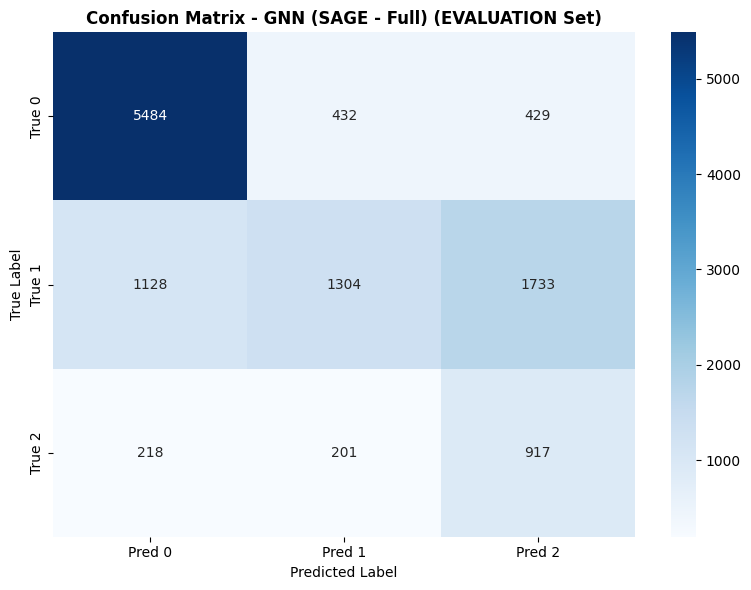

In [ ]:
# @title 19: Select Final Best Model
# Select based on highest MCC on the evaluation set
if evaluation_set_metrics:
    # Ensure metrics with NaN are handled, e.g. by filtering or assigning low value
    valid_metrics = {name: metrics for name, metrics in evaluation_set_metrics.items() if not np.isnan(metrics['mcc'])}
    if valid_metrics:
        FINAL_BEST_MODEL_NAME = max(valid_metrics.items(), key=lambda item: item[1]['mcc'])[0]
        print(f"Selected Final Best Model: {FINAL_BEST_MODEL_NAME} (MCC: {valid_metrics[FINAL_BEST_MODEL_NAME]['mcc']:.4f})")

        # Prepare the selected model for final evaluation on holdout and for explainability
        if FINAL_BEST_MODEL_NAME == 'Logistic Regression':
            final_model_object = lr_model
            final_model_is_gnn = False
        elif FINAL_BEST_MODEL_NAME == 'Random Forest':
            final_model_object = rf_model
            final_model_is_gnn = False
        elif FINAL_BEST_MODEL_NAME.startswith('GNN'):
            final_model_object = gnn_model # Assumes gnn_model holds the best GNN state
            final_model_is_gnn = True
            if 'Self-Loops' in FINAL_BEST_MODEL_NAME:
                 print("Warning: GNN (Self-Loops) selected. Ensure holdout data preparation reflects this for final eval.")
        elif FINAL_BEST_MODEL_NAME == 'Ensemble (LR+GNN)':
            final_model_object = None
            final_model_is_gnn = False
            print("Ensemble selected. Prediction logic will be reapplied on holdout.")
        else:
            print(f"Error: Model name {FINAL_BEST_MODEL_NAME} not recognized for final selection.")
            final_model_object = None
    else:
        print("No valid metrics to select the best model (all MCCs might be NaN).")
        FINAL_BEST_MODEL_NAME = None
        final_model_object = None
else:
    print("No evaluation metrics available to select the best model.")
    FINAL_BEST_MODEL_NAME = None
    final_model_object = None

# Confusion Matrix for the best model on EVALUATION set
if FINAL_BEST_MODEL_NAME and FINAL_BEST_MODEL_NAME in eval_predictions_results:
    best_eval_preds, _ = eval_predictions_results[FINAL_BEST_MODEL_NAME]
    cm_eval = confusion_matrix(y_eval_np, best_eval_preds, labels=np.arange(NUM_CLASSES))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Pred {i}' for i in range(NUM_CLASSES)],
                yticklabels=[f'True {i}' for i in range(NUM_CLASSES)])
    plt.title(f'Confusion Matrix - {FINAL_BEST_MODEL_NAME} (EVALUATION Set)', fontweight='bold')
    plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.tight_layout()
    plt.savefig(f'plots/confusion_matrix_{FINAL_BEST_MODEL_NAME.replace(" ", "_").replace("(", "").replace(")", "")}_eval_set.png', dpi=PLOT_DPI)
    plt.show()

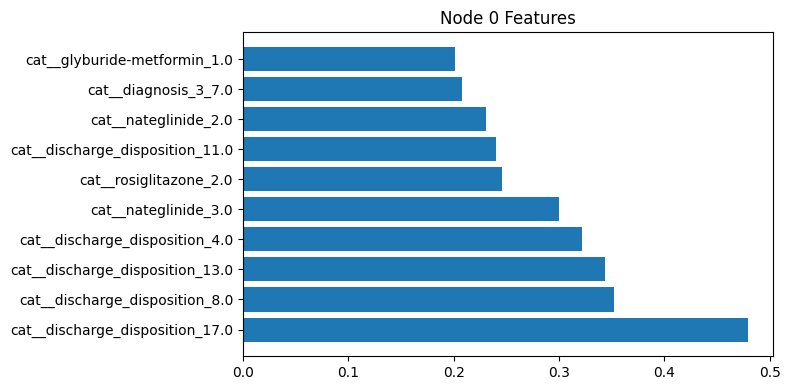

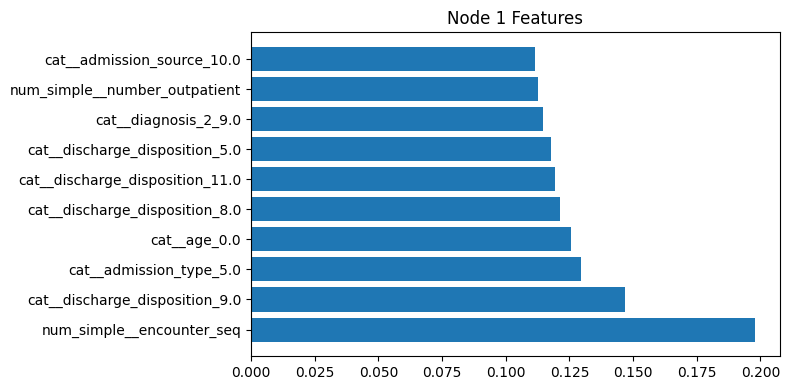

In [ ]:
#@title 20: model explainability

os.makedirs("explainability", exist_ok=True)

gnn_model.eval()
data = eval_data.to(DEVICE)

for node_id in [0, 1, 4][:min(3, data.num_nodes)]:
    try:
        x = data.x.clone().detach().requires_grad_(True)
        out = gnn_model(x, data.edge_index)
        if isinstance(out, tuple):
            out = out[0]

        target = data.y[node_id].item()
        if len(out.shape) > 1:
            out[node_id, target].backward()
        else:
            out[node_id].backward()

        importance = x.grad[node_id].abs().cpu().numpy()

        feat_names = [f"feat_{i}" for i in range(len(importance))]
        if 'preprocessor' in globals():
            try:
                feat_names = preprocessor.get_feature_names_out()
            except:
                pass

        daf = pd.DataFrame({'feature': feat_names[:len(importance)], 'importance': importance})
        daf = daf.nlargest(10, 'importance')

        plt.figure(figsize=(8, 4))
        plt.barh(daf['feature'], daf['importance'])
        plt.title(f'Node {node_id} Features')
        plt.tight_layout()
        plt.savefig(f'explainability/node_{node_id}.png')
        plt.show()
    except:
        pass

if 'lr_model' in globals() and hasattr(lr_model, 'coef_'):
    try:
        coeffs = lr_model.coef_
        imp = np.abs(coeffs.mean(axis=0) if coeffs.ndim > 1 else coeffs)

        feat_names = [f"feat_{i}" for i in range(len(imp))]
        if 'preprocessor' in globals():
            try:
                feat_names = preprocessor.get_feature_names_out()
            except:
                pass

        daf = pd.DataFrame({'feature': feat_names[:len(imp)], 'importance': imp})
        daf = daf.nlargest(15, 'importance')

        plt.figure(figsize=(8, 6))
        plt.barh(daf['feature'], daf['importance'])
        plt.title('LR Features')
        plt.tight_layout()
        plt.savefig('explainability/lr.png')
        plt.show()
    except:
        pass

In [ ]:
# @title 21: Final Model Evaluation on HOLD-OUT Set

if FINAL_BEST_MODEL_NAME and final_model_object is not None or FINAL_BEST_MODEL_NAME == 'Ensemble (LR+GNN)':
    print(f"Evaluating the selected best model: {FINAL_BEST_MODEL_NAME} on the HOLD-OUT set.")
    y_holdout_np = y_holdout.ravel()

    if FINAL_BEST_MODEL_NAME == 'Ensemble (LR+GNN)':
        print("Applying Ensemble logic for Hold-out set...")
        # Need LR and GNN predictions on holdout
        lr_holdout_preds, lr_holdout_probs = get_all_preds_probs(lr_model, X_holdout_final, is_gnn=False)
        gnn_model.eval() # ensure best gnn model is loaded and in eval
        gnn_full_holdout_preds, gnn_full_holdout_probs = get_all_preds_probs(gnn_model, None, holdout_data, is_gnn=True)

        final_preds = ((ENSEMBLE_WEIGHT_LR * lr_holdout_probs) + (ENSEMBLE_WEIGHT_GNN * gnn_full_holdout_probs)).argmax(axis=1)
        final_probs = (ENSEMBLE_WEIGHT_LR * lr_holdout_probs) + (ENSEMBLE_WEIGHT_GNN * gnn_full_holdout_probs)
    elif 'Self-Loops' in FINAL_BEST_MODEL_NAME:
        print("Applying GNN (Self-Loops) logic for Hold-out set...")
        final_model_object.eval()
        holdout_data_sl = holdout_data.clone()
        num_holdout_nodes = holdout_data_sl.num_nodes
        sl_edges_holdout = torch.arange(0, num_holdout_nodes, dtype=torch.long)
        holdout_data_sl.edge_index = torch.stack([sl_edges_holdout, sl_edges_holdout], dim=0)
        final_preds, final_probs = get_all_preds_probs(final_model_object, None, holdout_data_sl, is_gnn=True)
    else: # Single model (LR, RF, or GNN Full)
        final_model_object.eval()
        final_preds, final_probs = get_all_preds_probs(final_model_object, X_holdout_final, holdout_data, is_gnn=final_model_is_gnn)

    # Calculate final metrics
    acc_holdout = accuracy_score(y_holdout_np, final_preds)
    f1_holdout = f1_score(y_holdout_np, final_preds, average='macro', zero_division=0)
    mcc_holdout = matthews_corrcoef(y_holdout_np, final_preds)
    try:
        auc_holdout = roc_auc_score(y_holdout_np, final_probs, multi_class='ovr', average='macro')
    except:
        print("Warning: ROC AUC for Holdout failed. Set to nan")
        auc_holdout = np.nan

    print(f"Model: {FINAL_BEST_MODEL_NAME}")
    print(f"  Accuracy: {acc_holdout:.4f}")
    print(f"  F1-Macro: {f1_holdout:.4f}")
    print(f"  MCC:      {mcc_holdout:.4f}")
    print(f"  AUC (OVR Macro): {auc_holdout:.4f}")

    # Compare with Evaluation set performance to check for overfitting to the eval set
    if FINAL_BEST_MODEL_NAME in evaluation_set_metrics:
        eval_metrics = evaluation_set_metrics[FINAL_BEST_MODEL_NAME]
        print("\n--- Comparison: Evaluation Set vs. Hold-out Set ---")
        print(f"Metric      | Eval Set  | Hold-out Set | Difference (Holdout - Eval)")
        print(f"------------|-----------|--------------|--------------------------")
        print(f"Accuracy    | {eval_metrics['accuracy']:.4f}    | {acc_holdout:.4f}       | {acc_holdout - eval_metrics['accuracy']:.4f}")
        print(f"F1-Macro    | {eval_metrics['f1_macro']:.4f}    | {f1_holdout:.4f}       | {f1_holdout - eval_metrics['f1_macro']:.4f}")
        print(f"MCC         | {eval_metrics['mcc']:.4f}    | {mcc_holdout:.4f}       | {mcc_holdout - eval_metrics['mcc']:.4f}")
        if not np.isnan(eval_metrics['roc_auc']) and not np.isnan(auc_holdout):
            print(f"AUC         | {eval_metrics['roc_auc']:.4f}    | {auc_holdout:.4f}       | {auc_holdout - eval_metrics['roc_auc']:.4f}")

        if mcc_holdout < eval_metrics['mcc'] * 0.90: # e.g. >10% drop
            print("\nPotential Overfitting Warning: Significant drop in MCC from Evaluation to Hold-out set.")
        else:
            print("\nPerformance on Hold-out set is consistent with Evaluation set. Good generalization observed.")
    else:
        print("Could not retrieve evaluation set metrics for comparison.")

    # Confusion Matrix for Hold-out set
    cm_holdout = confusion_matrix(y_holdout_np, final_preds, labels=np.arange(NUM_CLASSES))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_holdout, annot=True, fmt='d', cmap='Greens',
                xticklabels=[f'Pred {i}' for i in range(NUM_CLASSES)],
                yticklabels=[f'True {i}' for i in range(NUM_CLASSES)])
    plt.title(f'Confusion Matrix - {FINAL_BEST_MODEL_NAME} (HOLD-OUT Set)', fontweight='bold')
    plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.tight_layout()
    plt.savefig(f'plots/confusion_matrix_{FINAL_BEST_MODEL_NAME.replace(" ", "_").replace("(", "").replace(")", "")}_holdout_set.png', dpi=PLOT_DPI)
    plt.show()

else:
    print("No best model was selected or available for final hold-out evaluation.")

Evaluating the selected best model: GNN (SAGE - Full) on the HOLD-OUT set.
Model: GNN (SAGE - Full)
  Accuracy: 0.6466
  F1-Macro: 0.5556
  MCC:      0.4375
  AUC (OVR Macro): 0.8228

--- Comparison: Evaluation Set vs. Hold-out Set ---
Metric      | Eval Set  | Hold-out Set | Difference (Holdout - Eval)
------------|-----------|--------------|--------------------------
Accuracy    | 0.6504    | 0.6466       | -0.0038
F1-Macro    | 0.5584    | 0.5556       | -0.0028
MCC         | 0.4431    | 0.4375       | -0.0056
AUC         | 0.8244    | 0.8228       | -0.0016

Performance on Hold-out set is consistent with Evaluation set. Good generalization observed.


Re-confirming performance for GNN (SAGE - Full) on the HOLD-OUT set.

--- Performance of GNN (SAGE - Full) on HOLD-OUT Set ---
  Accuracy:        0.6466
  F1-Macro:        0.5556
  MCC:             0.4375
  AUC (OVR Macro): 0.8228

Classification Report (Hold-Out Set):
              precision    recall  f1-score   support

     Class 0       0.80      0.86      0.83      6334
     Class 1       0.67      0.31      0.42      4167
     Class 2       0.30      0.69      0.42      1318

    accuracy                           0.65     11819
   macro avg       0.59      0.62      0.56     11819
weighted avg       0.70      0.65      0.64     11819



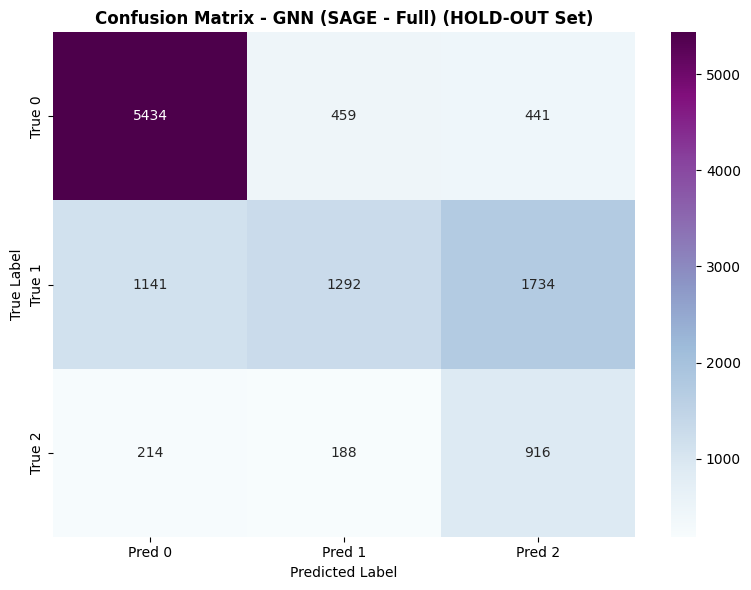

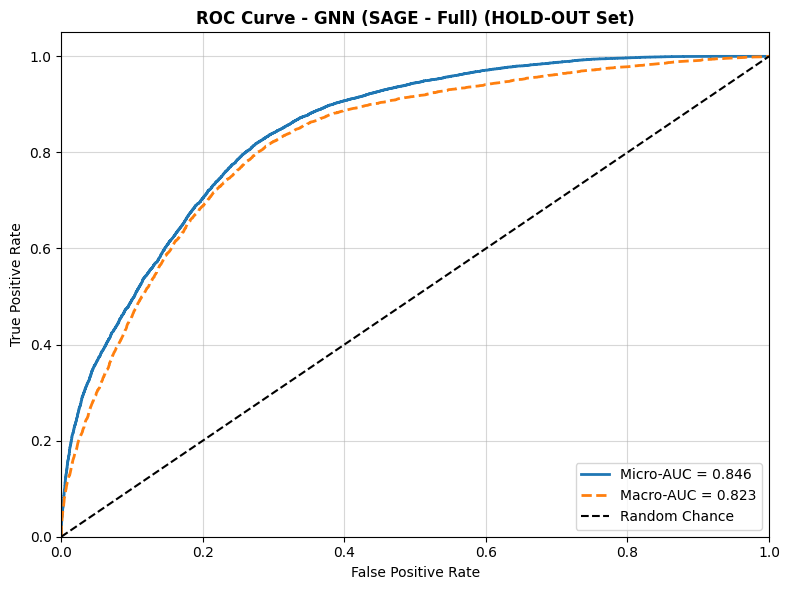

In [ ]:
# @title 22: GNN (SAGE - Full) - H-O set  performance re-check
TARGET_GNN_MODEL_NAME = f'GNN ({GNN_TYPE} - Full)'  # GNN_TYPE from Cell 2

if 'FINAL_BEST_MODEL_NAME' in locals() and FINAL_BEST_MODEL_NAME == TARGET_GNN_MODEL_NAME:
    print(f"Re-confirming performance for {TARGET_GNN_MODEL_NAME} on the HOLD-OUT set.")

    gnn_model.eval()
    gnn_model.to(DEVICE)

    y_holdout_np = y_holdout.ravel()

    try:
        gnn_holdout_preds, gnn_holdout_probs = get_all_preds_probs(
            model_obj=gnn_model,
            data_input_X=None,  # Not used for GNN
            data_input_pyg=holdout_data,
            is_gnn=True,
            gnn_device=DEVICE
        )
    except NameError:
        print("Error: `get_all_preds_probs` function not defined. Please ensure Cell 17 was run.")

    if 'gnn_holdout_preds' in locals():
        # Compute metrics
        acc = accuracy_score(y_holdout_np, gnn_holdout_preds)
        f1 = f1_score(y_holdout_np, gnn_holdout_preds, average='macro', zero_division=0)
        mcc = matthews_corrcoef(y_holdout_np, gnn_holdout_preds)
        try:
            auc_macro = roc_auc_score(y_holdout_np, gnn_holdout_probs, multi_class='ovr', average='macro')
        except ValueError as e:
            print(f"Warning: ROC AUC for GNN on Holdout failed: {e}. Setting to NaN.")
            auc_macro = np.nan

        print(f"\n--- Performance of {TARGET_GNN_MODEL_NAME} on HOLD-OUT Set ---")
        print(f"  Accuracy:        {acc:.4f}")
        print(f"  F1-Macro:        {f1:.4f}")
        print(f"  MCC:             {mcc:.4f}")
        print(f"  AUC (OVR Macro): {auc_macro:.4f}")

        # Classification Report
        print("\nClassification Report (Hold-Out Set):")
        if 'NUM_CLASSES' not in locals():
            NUM_CLASSES = len(np.unique(y_holdout_np))
        target_names = [f'Class {i}' for i in range(NUM_CLASSES)]
        print(classification_report(y_holdout_np, gnn_holdout_preds,
                                    target_names=target_names, zero_division=0))

        # Confusion Matrix
        cm = confusion_matrix(y_holdout_np, gnn_holdout_preds, labels=np.arange(NUM_CLASSES))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu',
                    xticklabels=[f'Pred {i}' for i in range(NUM_CLASSES)],
                    yticklabels=[f'True {i}' for i in range(NUM_CLASSES)])
        plt.title(f'Confusion Matrix - {TARGET_GNN_MODEL_NAME} (HOLD-OUT Set)', fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'plots/cm_{TARGET_GNN_MODEL_NAME.replace(" ", "_")}_holdout_set.png', dpi=PLOT_DPI)
        plt.show()

        # Combined ROC Curve (Micro & Macro Average)
        plt.figure(figsize=(8, 6))
        y_bin = pd.get_dummies(y_holdout_np).values
        if gnn_holdout_probs.shape[1] == y_bin.shape[1]:
            # Micro-average
            fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), gnn_holdout_probs.ravel())
            auc_micro = auc(fpr_micro, tpr_micro)
            # Macro-average
            fpr = {}
            tpr = {}
            for i in range(y_bin.shape[1]):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], gnn_holdout_probs[:, i])
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_bin.shape[1])]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(y_bin.shape[1]):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= y_bin.shape[1]
            auc_macro_curve = auc(all_fpr, mean_tpr)

            plt.plot(fpr_micro, tpr_micro, linestyle='-', lw=2,
                     label=f'Micro-AUC = {auc_micro:.3f}')
            plt.plot(all_fpr, mean_tpr, linestyle='--', lw=2,
                     label=f'Macro-AUC = {auc_macro_curve:.3f}')
            plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Chance')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {TARGET_GNN_MODEL_NAME} (HOLD-OUT Set)', fontweight='bold')
            plt.legend(loc='lower right')
            plt.grid(alpha=0.5)
            plt.tight_layout()
            plt.savefig(f'plots/roc_{TARGET_GNN_MODEL_NAME.replace(" ", "_")}_holdout_set_combined.png', dpi=PLOT_DPI)
            plt.show()
        else:
            print(f"Skipping ROC plot due to prob shape mismatch: {gnn_holdout_probs.shape} vs {y_bin.shape}")
    else:
        print(f"{TARGET_GNN_MODEL_NAME} predictions not generated for holdout. Cannot report metrics.")

elif 'FINAL_BEST_MODEL_NAME' in locals():
    print(f"The selected best model was {FINAL_BEST_MODEL_NAME}, not {TARGET_GNN_MODEL_NAME}. Skipping.")
else:
    print("FINAL_BEST_MODEL_NAME not determined. Skipping hold-out re-confirmation.")


prepare and retrain GNN (SAGE - Full) on all data excluding the hold-out set.
Full  selected. Shape: (67364, 35)

Preprocessing 
  Processed features shape: (67364, 149)
  Labels shape: (67364,)


Building Edges for Split:   0%|          | 0/47592 [00:00<?, ?it/s]

  Full_train_corpus_graph_data: Data(x=[67364, 149], edge_index=[2, 106908], y=[67364], num_nodes=67364)
    Nodes: 67364, Edges: 106908

Initialized : 251,652 params
Recomputed class weights for full training corpus: [0.62486898 0.94074602 2.970194  ]
Final re-training with LR: 0.0005, Max Epochs: 450

Starting final re-training on the full (non-holdout) ...


Final GNN Re-training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 25/450 - Full Corpus Training Loss: 0.9717
Epoch 50/450 - Full Corpus Training Loss: 0.8602
Epoch 75/450 - Full Corpus Training Loss: 0.8160
Epoch 100/450 - Full Corpus Training Loss: 0.7927
Epoch 125/450 - Full Corpus Training Loss: 0.7745
Epoch 150/450 - Full Corpus Training Loss: 0.7586
Epoch 175/450 - Full Corpus Training Loss: 0.7453
Epoch 200/450 - Full Corpus Training Loss: 0.7332
Epoch 225/450 - Full Corpus Training Loss: 0.7226
Epoch 250/450 - Full Corpus Training Loss: 0.7124
Epoch 275/450 - Full Corpus Training Loss: 0.7056
Epoch 300/450 - Full Corpus Training Loss: 0.7000
Epoch 325/450 - Full Corpus Training Loss: 0.6891
Epoch 350/450 - Full Corpus Training Loss: 0.6830
Epoch 375/450 - Full Corpus Training Loss: 0.6789
Epoch 400/450 - Full Corpus Training Loss: 0.6743
Epoch 425/450 - Full Corpus Training Loss: 0.6613
Epoch 450/450 - Full Corpus Training Loss: 0.6580
Final re-training finished.


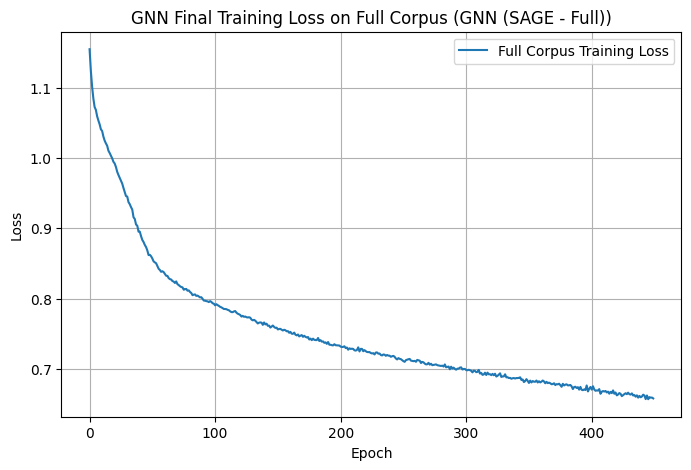


final production GNN model (trained on all non-holdout data) saved to: models/ultimate_production_gnn_SAGE_full_data.pt


In [ ]:
# @title 23: re-train GNN on full data (excluding hold-out) & save

TARGET_GNN_MODEL_NAME_FOR_FULL_RETRAIN = f'GNN ({GNN_TYPE} - Full)' #full cause full training

if 'df' not in locals() or 'holdout_patients' not in locals() or 'preprocessor' not in locals():
    print("Error:")
else:
    print(f"prepare and retrain {TARGET_GNN_MODEL_NAME_FOR_FULL_RETRAIN} on all data excluding the hold-out set.")

    # Create the "full training corpus":  (all data except hold-out)
    df_full_train_corpus_meta = df[~df['patient_nbr'].isin(holdout_patients)].copy()

    if df_full_train_corpus_meta.empty:
        print("Error")
    else:
        print(f"Full  selected. Shape: {df_full_train_corpus_meta.shape}")

        # Preprocess this Full Training Corpus
        print("\nPreprocessing ")
        try:
            X_full_train_corpus_final = preprocessor.transform(df_full_train_corpus_meta[MODEL_FEATURES])
            y_full_train_corpus = df_full_train_corpus_meta[TARGET_COLUMN].values
            print(f"  Processed features shape: {X_full_train_corpus_final.shape}")
            print(f"  Labels shape: {y_full_train_corpus.shape}")
        except:
            print("error")
            X_full_train_corpus_final = None # Mark as failed

        if X_full_train_corpus_final is not None:
            try:
                full_train_corpus_graph_data = create_graph_data_pyg(
                    df_split_meta=df_full_train_corpus_meta, # This df provides patient_nbr, encounter_seq, and index for mapping
                    X_features_split=X_full_train_corpus_final,
                    y_labels_split=y_full_train_corpus
                )
                print(f"  Full_train_corpus_graph_data: {full_train_corpus_graph_data}")
                print(f"    Nodes: {full_train_corpus_graph_data.num_nodes}, Edges: {full_train_corpus_graph_data.num_edges}")
                full_train_corpus_graph_data = full_train_corpus_graph_data.to(DEVICE)
            except NameError:
                print("  Error.")
                full_train_corpus_graph_data = None
            except Exception as e:
                print(f"  Error: {e}")
                full_train_corpus_graph_data = None


            if full_train_corpus_graph_data and full_train_corpus_graph_data.num_nodes > 0 :
                # "production" is meant to be the one 'deployed' or the one we use for csv testing
                production_gnn_model_final = AdvancedGNN(
                    num_features=NUM_PROC_FEATURES,
                    hidden_dim=GNN_HIDDEN_DIM,
                    num_classes=NUM_CLASSES,
                    dropout=GNN_DROPOUT,
                    num_layers=GNN_NUM_LAYERS,
                    gnn_type=GNN_TYPE
                ).to(DEVICE)

                print(f"\nInitialized : {sum(p.numel() for p in production_gnn_model_final.parameters() if p.requires_grad):,} params")

                # Define Optimizer and Loss
                FINAL_RETRAIN_LR = GNN_LEARNING_RATE * 0.5
                FINAL_RETRAIN_EPOCHS = GNN_EPOCHS + 50

                optimizer_final_prod = torch.optim.AdamW(production_gnn_model_final.parameters(), lr=FINAL_RETRAIN_LR, weight_decay=GNN_WEIGHT_DECAY)
                unique_classes_full_train = np.unique(y_full_train_corpus)
                class_weights_full_train_array = compute_class_weight(
                    class_weight='balanced',
                    classes=unique_classes_full_train,
                    y=y_full_train_corpus
                )
                CLASS_WEIGHTS_FULL_TRAIN_TENSOR = torch.FloatTensor(class_weights_full_train_array).to(DEVICE)
                print(f"Recomputed class weights for full training corpus: {class_weights_full_train_array}")

                criterion_final_prod = torch.nn.CrossEntropyLoss(weight=CLASS_WEIGHTS_FULL_TRAIN_TENSOR)

                print(f"Final re-training with LR: {FINAL_RETRAIN_LR}, Max Epochs: {FINAL_RETRAIN_EPOCHS}")

                # Re-training Loop
                final_prod_train_losses = []
                print("\nStarting final re-training on the full (non-holdout) ...")
                for epoch in tqdm(range(FINAL_RETRAIN_EPOCHS), desc="Final GNN Re-training"):
                    production_gnn_model_final.train()
                    optimizer_final_prod.zero_grad()

                    out_final_prod, _ = production_gnn_model_final(full_train_corpus_graph_data.x, full_train_corpus_graph_data.edge_index)
                    loss_final_prod = criterion_final_prod(out_final_prod, full_train_corpus_graph_data.y)

                    loss_final_prod.backward()
                    torch.nn.utils.clip_grad_norm_(production_gnn_model_final.parameters(), 1.0)
                    optimizer_final_prod.step()
                    final_prod_train_losses.append(loss_final_prod.item())

                    if (epoch + 1) % 25 == 0 or epoch == FINAL_RETRAIN_EPOCHS - 1:
                        print(f"Epoch {epoch+1}/{FINAL_RETRAIN_EPOCHS} - Full Corpus Training Loss: {loss_final_prod.item():.4f}")

                print("Final re-training finished.")

                # Plot loss
                plt.figure(figsize=(8, 5))
                plt.plot(final_prod_train_losses, label='Full Corpus Training Loss')
                plt.title(f'GNN Final Training Loss on Full Corpus ({TARGET_GNN_MODEL_NAME_FOR_FULL_RETRAIN})')
                plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
                plt.savefig(f'plots/final_retrain_loss_{TARGET_GNN_MODEL_NAME_FOR_FULL_RETRAIN.replace(" ", "_")}.png', dpi=PLOT_DPI)
                plt.show()

                # Save
                ultimate_production_model_filename = f'models/ultimate_production_gnn_{GNN_TYPE}_full_data.pt'
                torch.save(production_gnn_model_final.state_dict(), ultimate_production_model_filename)
                print(f"\nfinal production GNN model (trained on all non-holdout data) saved to: {ultimate_production_model_filename}")



            elif full_train_corpus_graph_data and full_train_corpus_graph_data.num_nodes == 0:
                print("error")
            else: # If graph_data is None or other issues
                print("error.")
        else: # If X_full_train_corpus_final is None
            print("error")

Loading from: models/ultimate_production_gnn_SAGE_full_data.pt
loaded model state_dict .

on the HOLD-OUT set...
  (Trained on all data except hold-out)
  Accuracy:        0.6331
  F1-Macro:        0.5493
  MCC:             0.4305
  AUC (OVR Macro): 0.8124

Classification Report :
              precision    recall  f1-score   support

     Class 0       0.80      0.82      0.81      6334
     Class 1       0.74      0.33      0.46      4167
     Class 2       0.26      0.69      0.38      1318

    accuracy                           0.63     11819
   macro avg       0.60      0.61      0.55     11819
weighted avg       0.72      0.63      0.64     11819



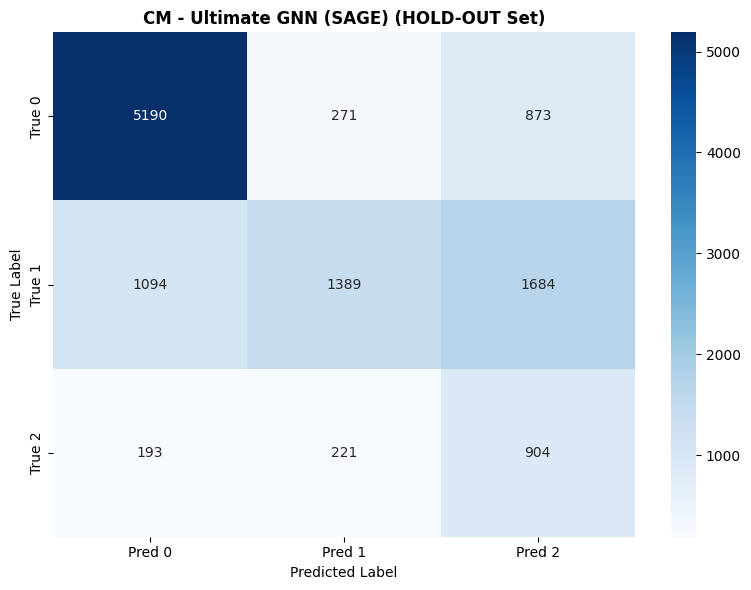

In [ ]:
# @title 24: Sanity Check of Ultimate Production GNN on Hold-Out Set (Simplified)

ultimate_model_filename = f'models/ultimate_production_gnn_{GNN_TYPE}_full_data.pt'

if not os.path.exists(ultimate_model_filename):
    print(f"Error file not found at '{ultimate_model_filename}'.")
else:
    print(f"Loading from: {ultimate_model_filename}")

    # Initialize
    try:
        sanity_check_gnn_model = AdvancedGNN(
            num_features=NUM_PROC_FEATURES,
            hidden_dim=GNN_HIDDEN_DIM,
            num_classes=NUM_CLASSES,
            dropout=GNN_DROPOUT,
            num_layers=GNN_NUM_LAYERS,
            gnn_type=GNN_TYPE
        ).to(DEVICE)
    except NameError as e:
        print(f"rror : {e}. hyperparameter might be missing.")
        sanity_check_gnn_model = None

    if sanity_check_gnn_model:
        try:
            sanity_check_gnn_model.load_state_dict(torch.load(ultimate_model_filename, map_location=DEVICE))
            sanity_check_gnn_model.eval()
            print("loaded model state_dict .")
        except Exception as e:
            print(f"Error : {e}")
            sanity_check_gnn_model = None

    if sanity_check_gnn_model:
        # Evaluate on the Hold-Out Set
        print("\non the HOLD-OUT set...")
        y_holdout_np = y_holdout.ravel()

        try:
            ultimate_gnn_holdout_preds, ultimate_gnn_holdout_probs = get_all_preds_probs(
                model_obj=sanity_check_gnn_model,
                data_input_X=None, # Not used for GNN
                data_input_pyg=holdout_data, # holdout_data
                is_gnn=True,
                gnn_device=DEVICE
            )
        except NameError as e:
            print(f"Error : {e}. ")
            ultimate_gnn_holdout_preds = None
            ultimate_gnn_holdout_probs = None


        if ultimate_gnn_holdout_preds is not None and ultimate_gnn_holdout_probs is not None:
            # Calculate metrics
            acc_ultimate_holdout = accuracy_score(y_holdout_np, ultimate_gnn_holdout_preds)
            f1_ultimate_holdout = f1_score(y_holdout_np, ultimate_gnn_holdout_preds, average='macro', zero_division=0)
            mcc_ultimate_holdout = matthews_corrcoef(y_holdout_np, ultimate_gnn_holdout_preds)
            try:
                auc_ultimate_holdout = roc_auc_score(y_holdout_np, ultimate_gnn_holdout_probs, multi_class='ovr', average='macro')
            except ValueError as e:
                print(f"Warning: {e}.  NaN.")
                auc_ultimate_holdout = np.nan
            print(f"  (Trained on all data except hold-out)")
            print(f"  Accuracy:        {acc_ultimate_holdout:.4f}")
            print(f"  F1-Macro:        {f1_ultimate_holdout:.4f}")
            print(f"  MCC:             {mcc_ultimate_holdout:.4f}")
            print(f"  AUC (OVR Macro): {auc_ultimate_holdout:.4f}")

            # Classification Report
            print("\nClassification Report :")
            target_names_report_ult = [f'Class {i}' for i in range(NUM_CLASSES)] # NUM_CLASSES from Cell 5
            print(classification_report(y_holdout_np, ultimate_gnn_holdout_preds, target_names=target_names_report_ult, zero_division=0))

            # Confusion Matrix
            cm_ultimate_holdout = confusion_matrix(y_holdout_np, ultimate_gnn_holdout_preds, labels=np.arange(NUM_CLASSES))
            plt.figure(figsize=(8,6))
            sns.heatmap(cm_ultimate_holdout, annot=True, fmt='d', cmap='Blues', # Simplified cmap
                        xticklabels=[f'Pred {i}' for i in range(NUM_CLASSES)],
                        yticklabels=[f'True {i}' for i in range(NUM_CLASSES)])
            plt.title(f'CM - Ultimate GNN ({GNN_TYPE}) (HOLD-OUT Set)', fontweight='bold')
            plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.tight_layout()
            plt.savefig(f'plots/cm_ultimate_gnn_{GNN_TYPE}_holdout_set.png', dpi=PLOT_DPI)
            plt.show()
        else:
            print("Skipping")
    else:
        print("Skipping")

In [ ]:
#@title 25: Prediction file creation
# Configuration
NEW_TEST_DATA_PATH = 'diabetes_test.csv'
SAVED_MODEL_PATH = 'models/ultimate_production_gnn_SAGE_full_data.pt'
OUTPUT_CSV_FILENAME = 'predictions.csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Columns to drop from test data
COLS_TO_DROP = [
    'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult',
    'acetohexamide', 'tolbutamide', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Model hyperparameters

def load_and_preprocess_test_data(file_path, cols_to_drop, model_features, preprocessor):

    # Load
    try:
        df_test = pd.read_csv(file_path)
        print(f"Data loaded. Shape: {df_test.shape}")
    except FileNotFoundError:
        print("File not found")
        return None, None, None, None
    except:
        print("error")
        return None, None, None, None

    # Save IDs
    if not all(col in df_test.columns for col in ['encounter_id', 'patient_nbr']):
        print("'encounter_id' or 'patient_nbr' missing")
        return None, None, None, None

    encounter_ids = df_test['encounter_id'].values
    patient_ids = df_test['patient_nbr'].values

    # Drop specified columns
    actual_cols_to_drop = [col for col in cols_to_drop if col in df_test.columns]
    if actual_cols_to_drop:
        df_test.drop(columns=actual_cols_to_drop, inplace=True)
        print(f"Dropped {len(actual_cols_to_drop)} columns: {actual_cols_to_drop}")
    else:
        print("No columns to drop found ")

    # Feature engineering
    if 'patient_nbr' in df_test.columns and 'encounter_id' in df_test.columns:
        # Sort by patient and encounter for sequence features
        df_test = df_test.sort_values(['patient_nbr', 'encounter_id'])

        # encounter_seq
        if 'encounter_seq' in model_features:
            df_test['encounter_seq'] = df_test.groupby('patient_nbr').cumcount()

    print(f"  shape: {df_test.shape}")

    #missing features
    missing_features = [feat for feat in model_features if feat not in df_test.columns]
    if missing_features:
        print(f"Missing : {missing_features}")
        return None, None, None, None

    # preprocessing (transform only - no fitting!)
    try:
        X_processed = preprocessor.transform(df_test[model_features])
        if X_processed.shape[1] != NUM_PROC_FEATURES:
            print("features shape mismatch.")
            return None, None, None, None
        print(f" Preprocessing completedshape: {X_processed.shape}")
    except:
        print("error")
        return None, None, None, None

    return X_processed, encounter_ids, patient_ids, df_test

def save_predictions(predictions_df, filename=OUTPUT_CSV_FILENAME):
    try:
        predictions_df.to_csv(filename, index=False)
        print(f"\nSample predictions:")
        print(predictions_df.head())
        return True
    except Exception as e:
        print("error")
        return False

def create_graph_and_predict(X_processed, df_test, encounter_ids, patient_ids, create_graph_function):
    try:
        dummy_labels = np.zeros(len(df_test), dtype=int)

        # Geometric graph
        test_graph = create_graph_function(df_test, X_processed, dummy_labels).to(DEVICE)

        if test_graph.num_nodes == 0:
            print("Created graph has 0 nodes")
            return None

        print(f" Nodes: {test_graph.num_nodes}, Edges: {test_graph.num_edges}")

    except:
        print("error")
        import traceback
        traceback.print_exc()
        return None

    # Initialize
    model = AdvancedGNN(
        num_features=NUM_PROC_FEATURES,
        hidden_dim=GNN_HIDDEN_DIM,
        num_classes=NUM_CLASSES,
        dropout=GNN_DROPOUT,
        num_layers=GNN_NUM_LAYERS,
        gnn_type=GNN_TYPE
    ).to(DEVICE)

    # Load saved model weights
    try:
        model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE))
        model.eval()
    except:
        print("error")
        return None

    # Make predictions
    with torch.no_grad():
        # Forward pass through the model
        logits, _ = model(test_graph.x, test_graph.edge_index)

        # Convert logits to probabilities
        probabilities = F.softmax(logits, dim=1).cpu().numpy()

        # Get predicted classes
        predicted_classes = torch.argmax(logits, dim=1).cpu().numpy()

    print(f"Predictions generated for {len(probabilities)} samples")

    # Create output DataFrame
    results_df = pd.DataFrame({
        'encounter_id': encounter_ids,
        'patient_nbr': patient_ids,
        'predicted_class': predicted_classes,
        'prob_NO': probabilities[:, 0],      # Class 0: No readmission
        'prob_gt30': probabilities[:, 1],    # Class 1: >30 days readmission
        'prob_lt30': probabilities[:, 2]     # Class 2: <30 days readmission
    })

    return results_df

#Complete Inference Pipeline
def run_complete_inference(model_features, preprocessor, create_graph_function):

    # Load and preprocess test data
    X_processed, encounter_ids, patient_ids, df_test = load_and_preprocess_test_data(
        NEW_TEST_DATA_PATH, COLS_TO_DROP, model_features, preprocessor
    )

    if X_processed is None:
        print("Data preprocessing failed")
        return None

    # Create graph and make predictions
    predictions = create_graph_and_predict(
        X_processed, df_test, encounter_ids, patient_ids, create_graph_function
    )

    if predictions is not None:
        # Save results
        success = save_predictions(predictions)

        if success:
            return predictions
    else:
        print("Prediction failed.")

    return None

# Simplified Inference
def run_inference_from_graph(test_graph, encounter_ids, patient_ids):
    # Initialize model with same architecture as training
    model = AdvancedGNN(
        num_features=NUM_PROC_FEATURES,
        hidden_dim=GNN_HIDDEN_DIM,
        num_classes=NUM_CLASSES,
        dropout=GNN_DROPOUT,
        num_layers=GNN_NUM_LAYERS,
        gnn_type=GNN_TYPE
    ).to(DEVICE)

    # Load saved model weights
    try:
        model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE))
        model.eval()
    except:
        print("error")
        return None

    # Make predictions
    with torch.no_grad():
        # Forward pass through the model
        logits, _ = model(test_graph.x, test_graph.edge_index)

        # Convert logits to probabilities
        probabilities = F.softmax(logits, dim=1).cpu().numpy()

        # Get predicted classes
        predicted_classes = torch.argmax(logits, dim=1).cpu().numpy()

    print(f"Predictionsfor {len(probabilities)} samples")

    # Create output DataFrame
    predictions = pd.DataFrame({
        'encounter_id': encounter_ids,
        'patient_nbr': patient_ids,
        'predicted_class': predicted_classes,
        'prob_NO': probabilities[:, 0],
        'prob_gt30': probabilities[:, 1],
        'prob_lt30': probabilities[:, 2]
    })

    if predictions is not None:
        success = save_predictions(predictions)
        if success:
            return predictions

    return None


if __name__ == "__main__":

    print(f"\nConfiguration:")
    print(f"- Test data path: {NEW_TEST_DATA_PATH}")
    print(f"- Model path: {SAVED_MODEL_PATH}")
    print(f"- Output file: {OUTPUT_CSV_FILENAME}")
    print(f"- Device: {DEVICE}")




Configuration:
- Test data path: diabetes_test.csv
- Model path: models/ultimate_production_gnn_SAGE_full_data.pt
- Output file: predictions.csv
- Device: cuda


In [ ]:
predictions = run_complete_inference(MODEL_FEATURES, preprocessor, create_graph_data_pyg)

Data loaded. Shape: (19513, 48)
Dropped 15 columns: ['payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'acetohexamide', 'tolbutamide', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
  shape: (19513, 34)
 Preprocessing completedshape: (19513, 149)


Building Edges for Split:   0%|          | 0/13998 [00:00<?, ?it/s]

 Nodes: 19513, Edges: 30543
Predictions generated for 19513 samples

Sample predictions:
   encounter_id  patient_nbr  predicted_class   prob_NO  prob_gt30  prob_lt30
0             7          927                0  0.513537   0.156323   0.330140
1            46        12240                2  0.302922   0.161228   0.535850
2            47        12258                0  0.539617   0.403721   0.056662
3            49        13005                0  0.755569   0.164587   0.079843
4            53        13590                0  0.611373   0.170523   0.218105
